# Load & Analyze Multiple Sheets

Load dataset metadata from multiple CSV sheets, each tagged with a training phase.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Toggle which token column to analyze ---
# Options: 'gemma3_token_cnt', 'desired_token_cnt'
# TOKEN_COL = 'gemma3_token_cnt'
TOKEN_COL = 'desired_token_cnt'

# --- Sheets to load: (file_path, training_phase) ---
SHEETS_DIR = '/Users/antoniorodriguez/Documents/datasets/sheets'
SHEETS = [
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - Phase1 (1).csv', 'SMoE-Phase1'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - Phase2-Anneal-32k.csv', 'SMoE-Phase2-Anneal-32k'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - Phase2 (1).csv', 'SMoE-Phase2'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - Bmoe-phase 1.csv', 'BMoE-Phase1'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - Bmoe-phase2.csv', 'BMoE-Phase2'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - SMoE-Reasoning-Midtrain.csv', 'SMoE-Midtrain'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - SMoE-Reasoning-Midtrain-CETX.csv', 'SMoE-Midtrain-CETX'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - smoe diffusion.csv', 'SMoE-Diffusion'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - SMoE-SFT.csv', 'SMoE-SFT'),
    (f'{SHEETS_DIR}/smoe_bmoe_datacard - SMoE-Reasoning-Midtrain.csv', 'SMoE-Midtrain')
]

## Load and Combine Sheets

In [2]:
frames = []
for path, phase in SHEETS:
    raw = pd.read_csv(path)

    # Validate required columns
    missing = [c for c in ['data_name_split', 'gemma3_token_cnt'] if c not in raw.columns]
    if missing:
        print(f'SKIPPING {path}: missing columns {missing}')
        continue

    # Clean gemma3_token_cnt
    raw['gemma3_token_cnt'] = raw['gemma3_token_cnt'].astype(str).str.replace(',', '').str.strip()
    raw['gemma3_token_cnt'] = pd.to_numeric(raw['gemma3_token_cnt'], errors='coerce')

    # Clean Documents and Epochs if present
    if 'Documents' in raw.columns:
        raw['Documents'] = raw['Documents'].astype(str).str.replace(',', '').str.strip()
        raw['Documents'] = pd.to_numeric(raw['Documents'], errors='coerce')
    if 'Epochs' in raw.columns:
        raw['Epochs'] = pd.to_numeric(raw['Epochs'], errors='coerce')

    # Keep only rows with valid name and positive token count
    raw = raw.dropna(subset=['data_name_split', 'gemma3_token_cnt'])
    raw = raw[raw['gemma3_token_cnt'] > 0]

    # Compute desired_token_cnt
    if 'Epochs' in raw.columns:
        raw['desired_token_cnt'] = raw['gemma3_token_cnt'] * raw['Epochs']
    else:
        raw['desired_token_cnt'] = np.nan

    raw['phase'] = phase
    frames.append(raw)
    print(f'Loaded {len(raw):>4} rows from {phase} ({path.split("/")[-1]})')

df = pd.concat(frames, ignore_index=True)
print(f'\nTotal rows: {len(df)}')
df.head()

Loaded   65 rows from SMoE-Phase1 (smoe_bmoe_datacard - Phase1 (1).csv)
Loaded  143 rows from SMoE-Phase2-Anneal-32k (smoe_bmoe_datacard - Phase2-Anneal-32k.csv)
Loaded  107 rows from SMoE-Phase2 (smoe_bmoe_datacard - Phase2 (1).csv)
Loaded  125 rows from BMoE-Phase1 (smoe_bmoe_datacard - Bmoe-phase 1.csv)
Loaded  133 rows from BMoE-Phase2 (smoe_bmoe_datacard - Bmoe-phase2.csv)
Loaded  143 rows from SMoE-Midtrain (smoe_bmoe_datacard - SMoE-Reasoning-Midtrain.csv)
Loaded  138 rows from SMoE-Midtrain-CETX (smoe_bmoe_datacard - SMoE-Reasoning-Midtrain-CETX.csv)
SKIPPING /Users/antoniorodriguez/Documents/datasets/sheets/smoe_bmoe_datacard - smoe diffusion.csv: missing columns ['data_name_split', 'gemma3_token_cnt']
Loaded   21 rows from SMoE-SFT (smoe_bmoe_datacard - SMoE-SFT.csv)
Loaded  143 rows from SMoE-Midtrain (smoe_bmoe_datacard - SMoE-Reasoning-Midtrain.csv)

Total rows: 1018


data_name_split     domain  \
0  Zyda-2/dclm-half-1  CRAWL-Gen   
1  Zyda-2/dclm-half-2  CRAWL-Gen   
2         Zyda-2/fwe3  CRAWL-Gen   
3        Zyda-2/dolma  CRAWL-Gen   
4         Zyda-2/zyda  CRAWL-Gen   

                                         weblink Size \n(processed_gemma3)  \
0  https://huggingface.co/datasets/Zyphra/Zyda-2                       6TB   
1  https://huggingface.co/datasets/Zyphra/Zyda-2                       6TB   
2  https://huggingface.co/datasets/Zyphra/Zyda-2                     4.8TB   
3  https://huggingface.co/datasets/Zyphra/Zyda-2                     894GB   
4  https://huggingface.co/datasets/Zyphra/Zyda-2                     616GB   

      Documents  gemma3_token_cnt  Epochs Desired Tokens (for 10T)  \
0  1.295465e+09      1.655233e+12   0.115          190,202,911,817   
1  1.294434e+09      1.653938e+12   0.115          190,351,845,299   
2  1.279083e+09      1.305122e+12   0.000                        0   
3  4.455819e+08      2.379934e+11   0.400           95,197,375,308   
4  2.476542e+08      1.642519e+11   1.000          164,251,856,421   

  Megatron Weights                                       ibm_datapath  ...  \
0         0.026093  /shared/datasets/processed_gemma3/zyda-2/dclm-...  ...   
1         0.026114  /shared/datasets/processed_gemma3/zyda-2/dclm-...  ...   
2              0.0  /shared/datasets/processed_gemma3/zyda-2/fwe3/...  ...   
3          0.01306  /shared/datasets/processed_gemma3/zyda-2/dolma...  ...   
4         0.022533  /shared/datasets/processed_gemma3/zyda-2/zyda/...  ...   

  Comments desired_token_cnt        phase Link Desired Tokens (for 8T)  \
0      NaN      1.903518e+11  SMoE-Phase1  NaN                     NaN   
1      NaN      1.902029e+11  SMoE-Phase1  NaN                     NaN   
2      NaN      0.000000e+00  SMoE-Phase1  NaN                     NaN   
3      NaN      9.519738e+10  SMoE-Phase1  NaN                     NaN   
4      NaN      1.642519e+11  SMoE-Phase1  NaN                     NaN   

  Weights Phase2 Epochs Desired Tokens  Unnamed: 15 Unnamed: 9  
0     NaN           NaN            NaN          NaN        NaN  
1     NaN           NaN            NaN          NaN        NaN  
2     NaN           NaN            NaN          NaN        NaN  
3     NaN           NaN            NaN          NaN        NaN  
4     NaN           NaN            NaN          NaN        NaN  

[5 rows x 27 columns]

In [3]:
# Basic statistics
print(f'Dataset Statistics (using {TOKEN_COL}):')
print(f'  Total datasets: {len(df)}')
print(f'  Total tokens: {df[TOKEN_COL].sum():,.0f}')
if 'Documents' in df.columns:
    print(f'  Total documents: {df["Documents"].sum():,.0f}')
print(f'\nBy phase:')
print(df.groupby('phase')[TOKEN_COL].agg(['count', 'sum']).rename(columns={'count': 'datasets', 'sum': 'total_tokens'}).to_string())
if 'domain' in df.columns:
    print(f'\nDomains: {df["domain"].nunique()}')
    print(f'\nBy domain:')
    print(df['domain'].value_counts().to_string())

Dataset Statistics (using desired_token_cnt):
  Total datasets: 1018
  Total tokens: 40,292,662,094,539
  Total documents: 155,773,144,541

By phase:
                        datasets  total_tokens
phase                                         
BMoE-Phase1                  125  8.597944e+12
BMoE-Phase2                  133  1.033064e+13
SMoE-Midtrain                264  2.739966e+12
SMoE-Midtrain-CETX           127  1.573666e+12
SMoE-Phase1                   54  7.289355e+12
SMoE-Phase2                   96  4.369597e+12
SMoE-Phase2-Anneal-32k       132  4.647919e+12
SMoE-SFT                      21  7.435695e+11

Domains: 39

By domain:
domain
CRAWL-Gen                      138
NR-4K                          126
MATH                           111
R-4K                            98
FEWSHOT                         84
R-32K                           72
CODE                            70
REASONING                       66
MULTILINGUAL                    57
SYN-CRAWL-HIGH                  3

## Domain Pie Charts

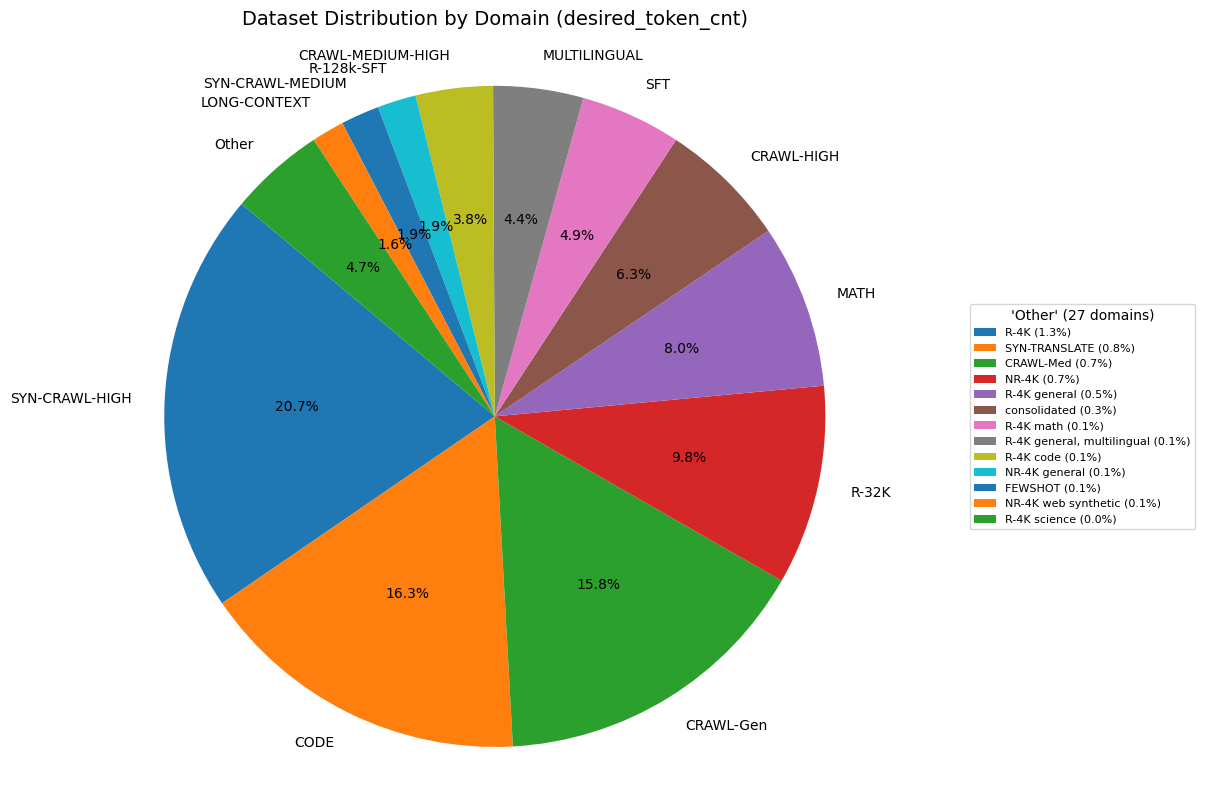

In [4]:
# Pie chart by token count per domain
df_domain = df.dropna(subset=['domain'])
domain_tokens = df_domain.groupby('domain')[TOKEN_COL].sum().sort_values(ascending=False)

total_tokens = domain_tokens.sum()
pct = (domain_tokens / total_tokens) * 100

large_domains = domain_tokens[pct >= 1.5]
small_domains = domain_tokens[pct < 1.5]

if not small_domains.empty:
    plot_data = pd.concat([large_domains, pd.Series({'Other': small_domains.sum()})])
else:
    plot_data = large_domains

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    plot_data, labels=plot_data.index, autopct='%1.1f%%',
    startangle=140, textprops={'fontsize': 10}
)

if not small_domains.empty:
    legend_labels = [f"{d} ({pct[d]:.1f}%)" for d in small_domains.index]
    plt.legend(legend_labels, title=f"'Other' ({len(small_domains)} domains)",
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.title(f'Dataset Distribution by Domain ({TOKEN_COL})', fontsize=14, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [5]:
# Pie chart by dataset count per domain
domain_counts = df_domain['domain'].value_counts()
total_count = domain_counts.sum()
pct_count = (domain_counts / total_count) * 100

large_by_count = domain_counts[pct_count >= 1.5]
small_by_count = domain_counts[pct_count < 1.5]

if not small_by_count.empty:
    plot_data = pd.concat([large_by_count, pd.Series({'Other': small_by_count.sum()})])
else:
    plot_data = large_by_count

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    plot_data, labels=plot_data.index, autopct='%1.1f%%',
    startangle=140, textprops={'fontsize': 10}
)

if not small_by_count.empty:
    legend_labels = [f"{d} ({pct_count[d]:.1f}%)" for d in small_by_count.index]
    plt.legend(legend_labels, title=f"'Other' ({len(small_by_count)} domains)",
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.title('Dataset Distribution by Domain (Dataset Count)', fontsize=14, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Histograms

In [6]:
# Overall token count distribution
valid = df[TOKEN_COL].replace([np.inf, -np.inf], np.nan).dropna()

plt.hist(valid / 1e9, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Token Count (Billions)')
plt.ylabel('Frequency')
plt.title(f'Distribution of {TOKEN_COL}')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# All top domains overlapping in one histogram
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(18, 10))

top_domains = df_domain['domain'].value_counts().head(10).index
colors = plt.cm.seismic(np.linspace(0, 1, len(top_domains)))

for idx, domain in enumerate(top_domains):
    data = df_domain[df_domain['domain'] == domain][TOKEN_COL].dropna()
    if data.empty:
        continue
    ax.hist(data / 1e9, bins=10, alpha=0.6, label=f'{domain} (n={len(data)})',
            color=colors[idx], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Token Count (Billions)', fontsize=20, fontweight='bold')
ax.set_ylabel('Number of Datasets', fontsize=20, fontweight='bold')
ax.set_title(f'Token Count Distribution - All Top 10 Domains ({TOKEN_COL})', fontsize=22, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1.02, 0.5),
          framealpha=0.95, edgecolor='black', title='Domains', title_fontsize=16)
ax.grid(axis='y', alpha=0.3, linewidth=1.5)
ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

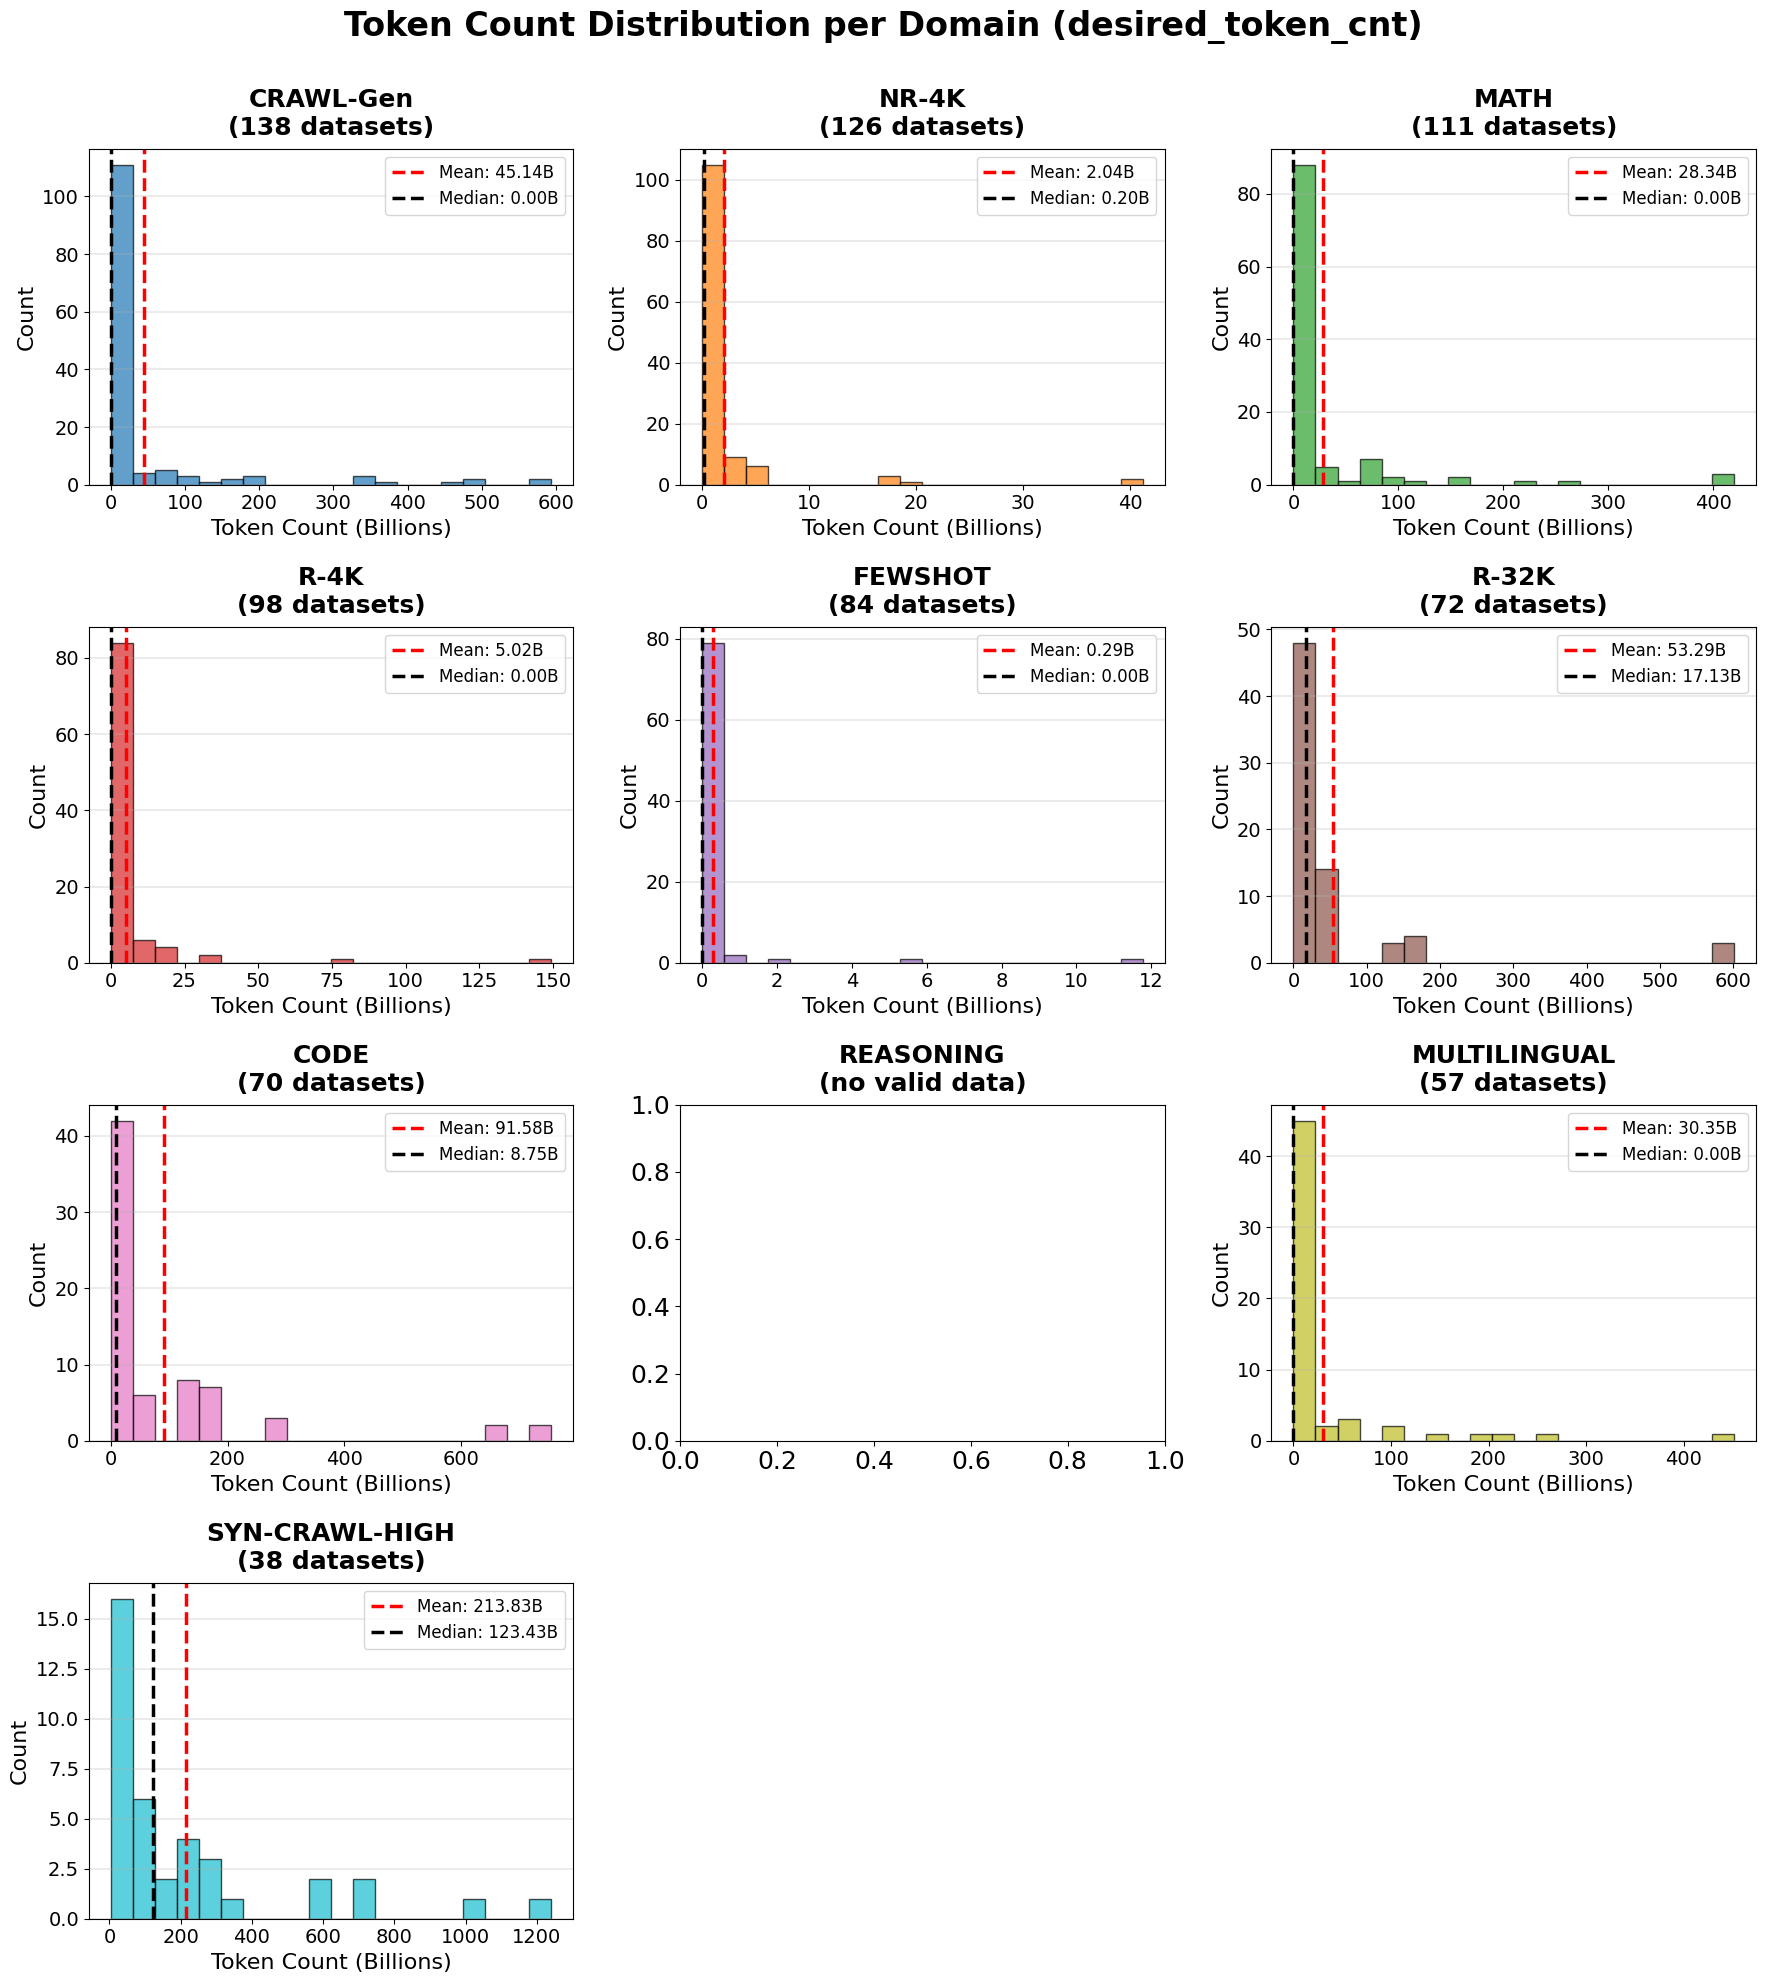

In [8]:
# Grid of individual histograms per domain
plt.rcParams.update({'font.size': 18})

top_domains = df_domain['domain'].value_counts().head(10).index
n_domains = len(top_domains)
n_cols = 3
n_rows = int(np.ceil(n_domains / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()
colors = plt.cm.tab10(np.linspace(0, 1, n_domains))

for idx, domain in enumerate(top_domains):
    data = df_domain[df_domain['domain'] == domain][TOKEN_COL].dropna()
    ax = axes[idx]
    if data.empty:
        ax.set_title(f'{domain}\n(no valid data)', fontsize=18, fontweight='bold', pad=10)
        continue
    ax.hist(data / 1e9, bins=20, edgecolor='black', alpha=0.7, color=colors[idx])
    ax.set_title(f'{domain}\n({len(data)} datasets)', fontsize=18, fontweight='bold', pad=10)
    ax.set_xlabel('Token Count (Billions)', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.grid(axis='y', alpha=0.3, linewidth=1.2)
    ax.tick_params(labelsize=14)

    mean_val = data.mean() / 1e9
    median_val = data.median() / 1e9
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2.5, label=f'Mean: {mean_val:.2f}B')
    ax.axvline(median_val, color='k', linestyle='--', linewidth=2.5, label=f'Median: {median_val:.2f}B')
    ax.legend(fontsize=12, loc='upper right')

for idx in range(n_domains, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Token Count Distribution per Domain ({TOKEN_COL})', fontsize=24, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Per-Phase Analysis

Pie charts and histograms broken down by training phase.

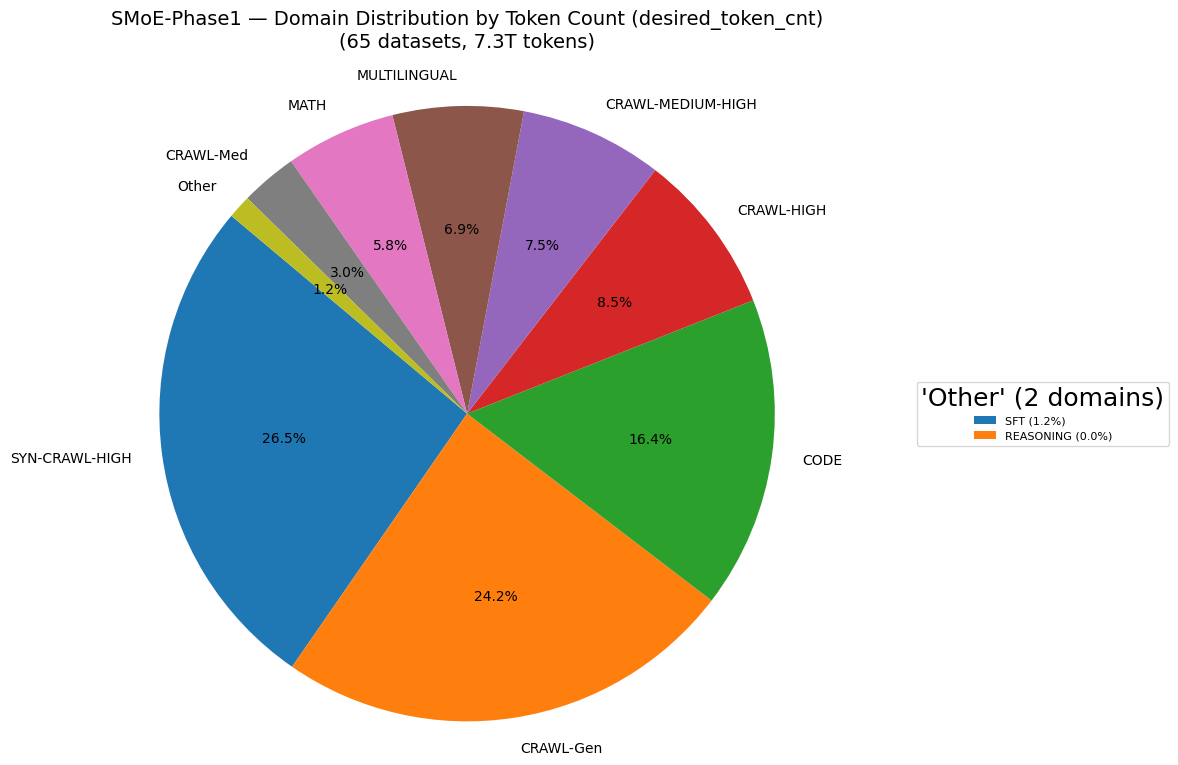

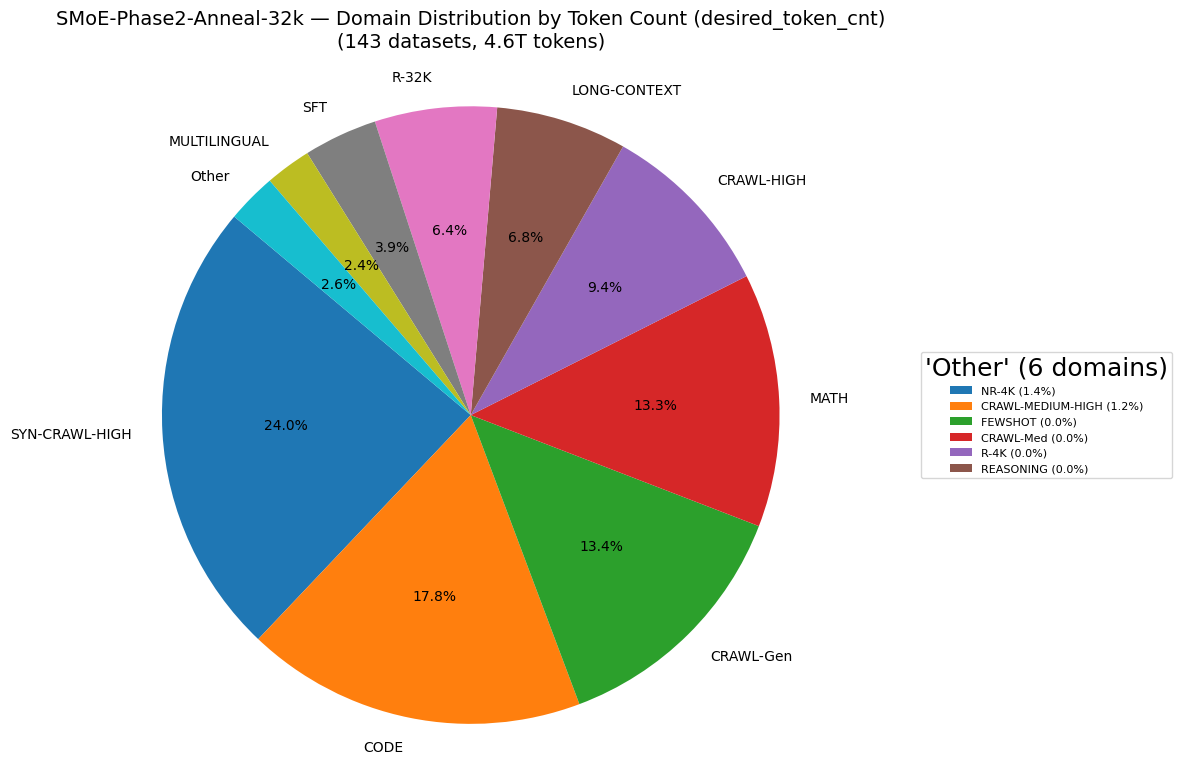

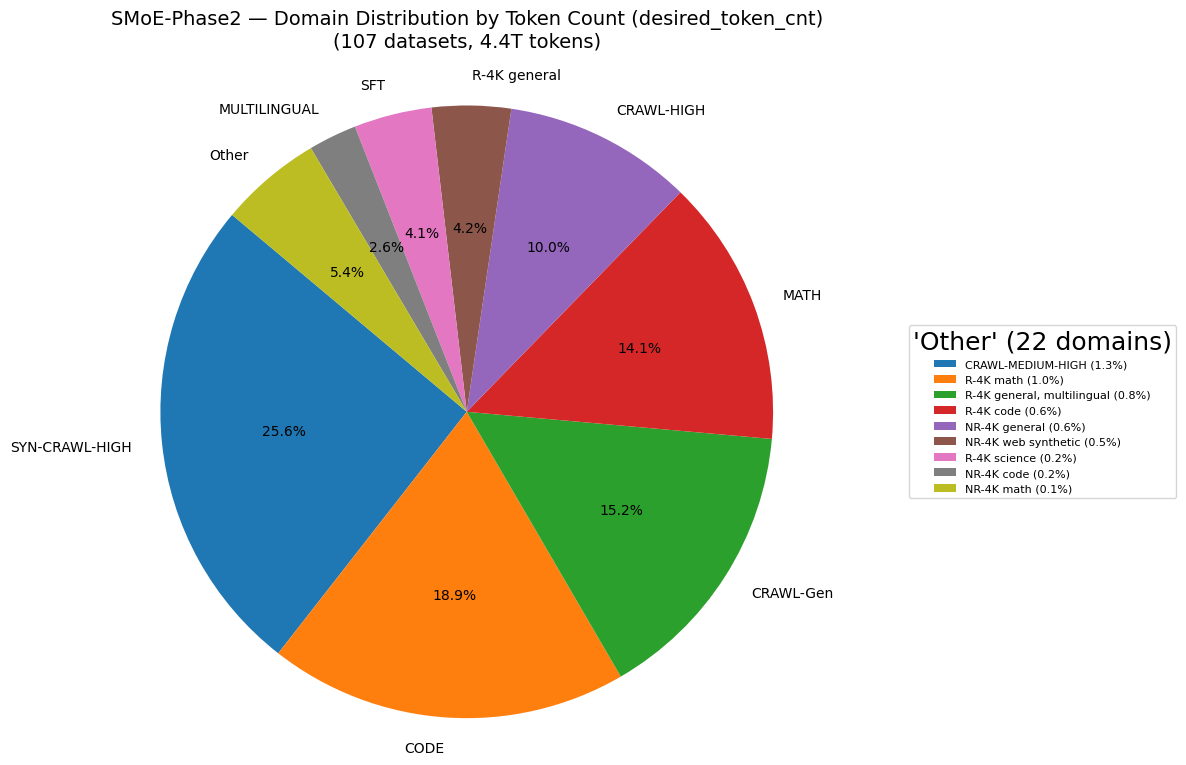

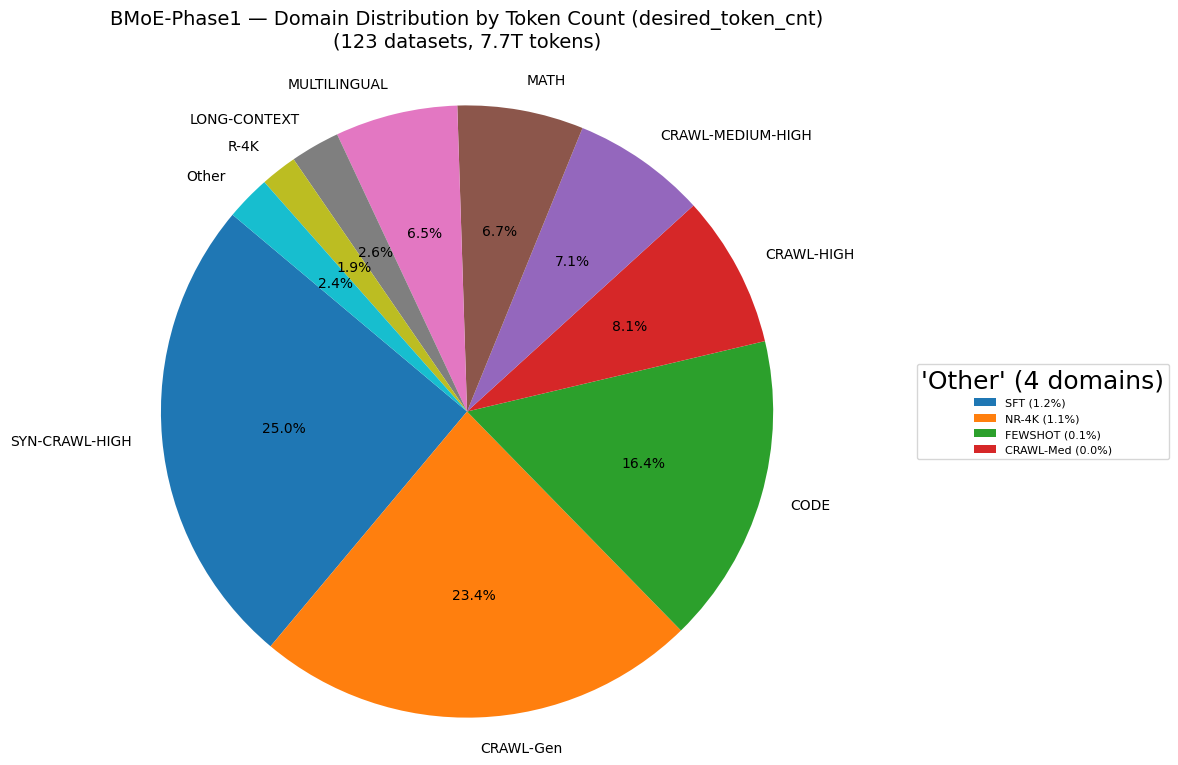

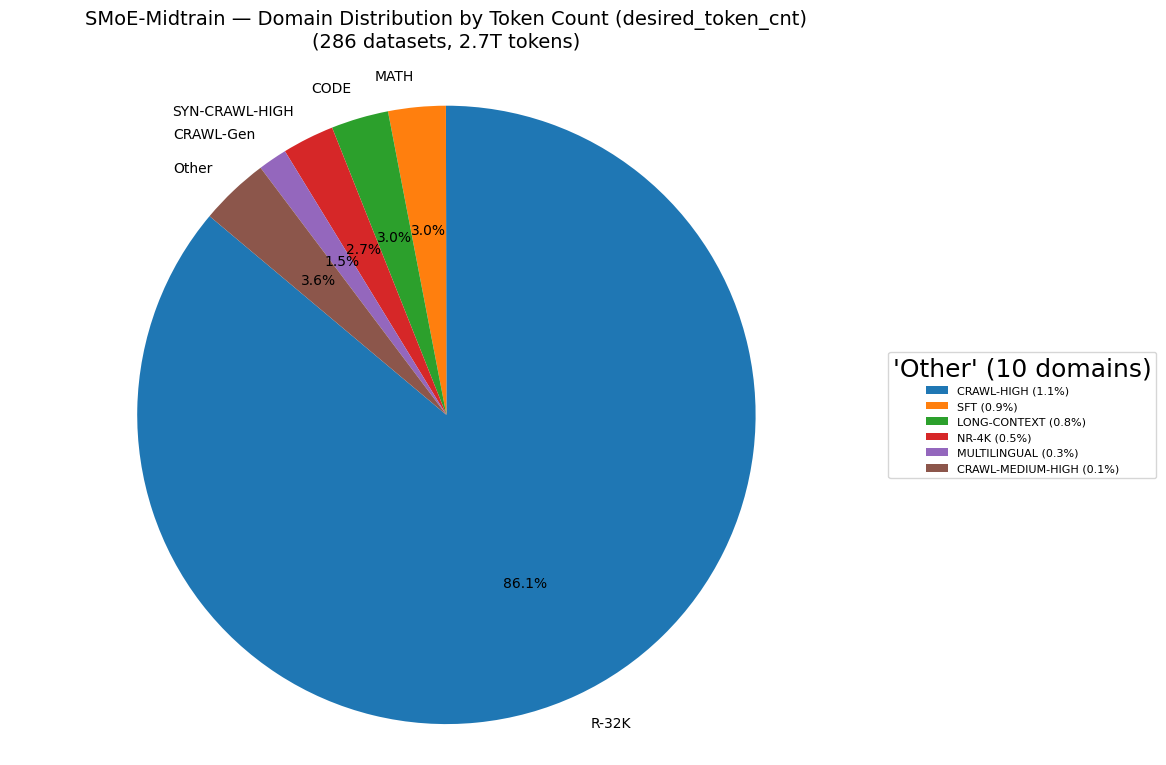

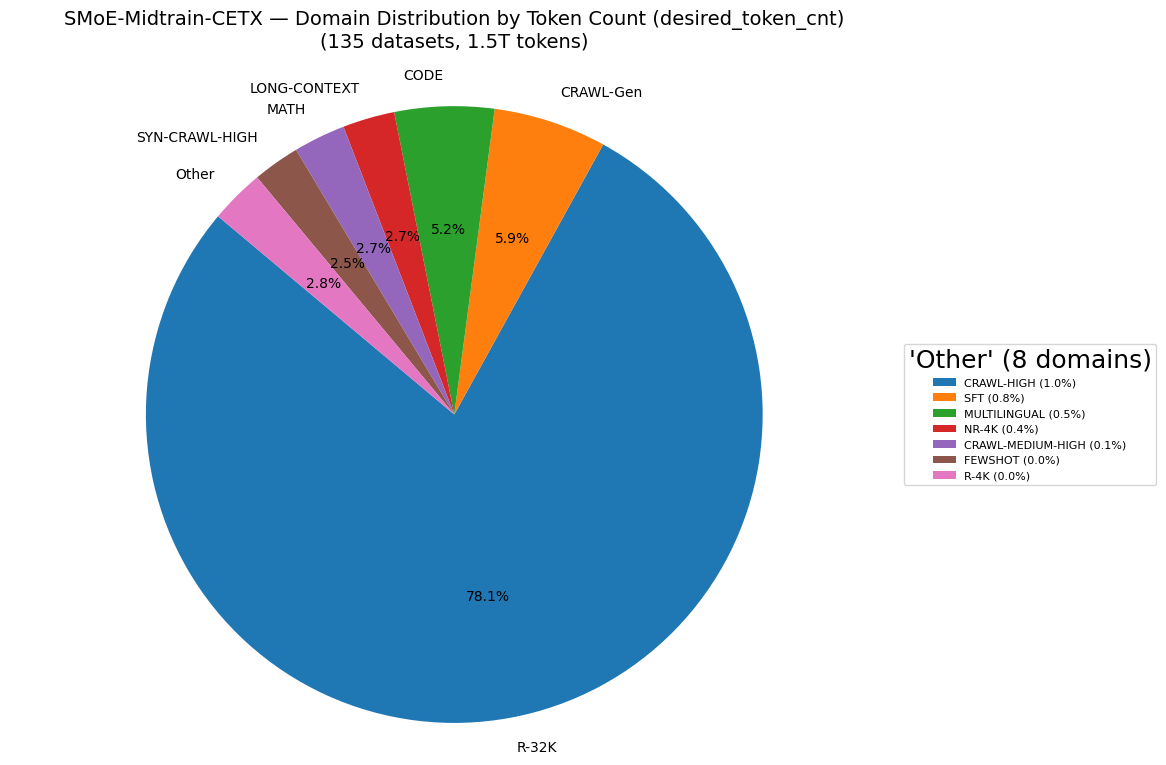

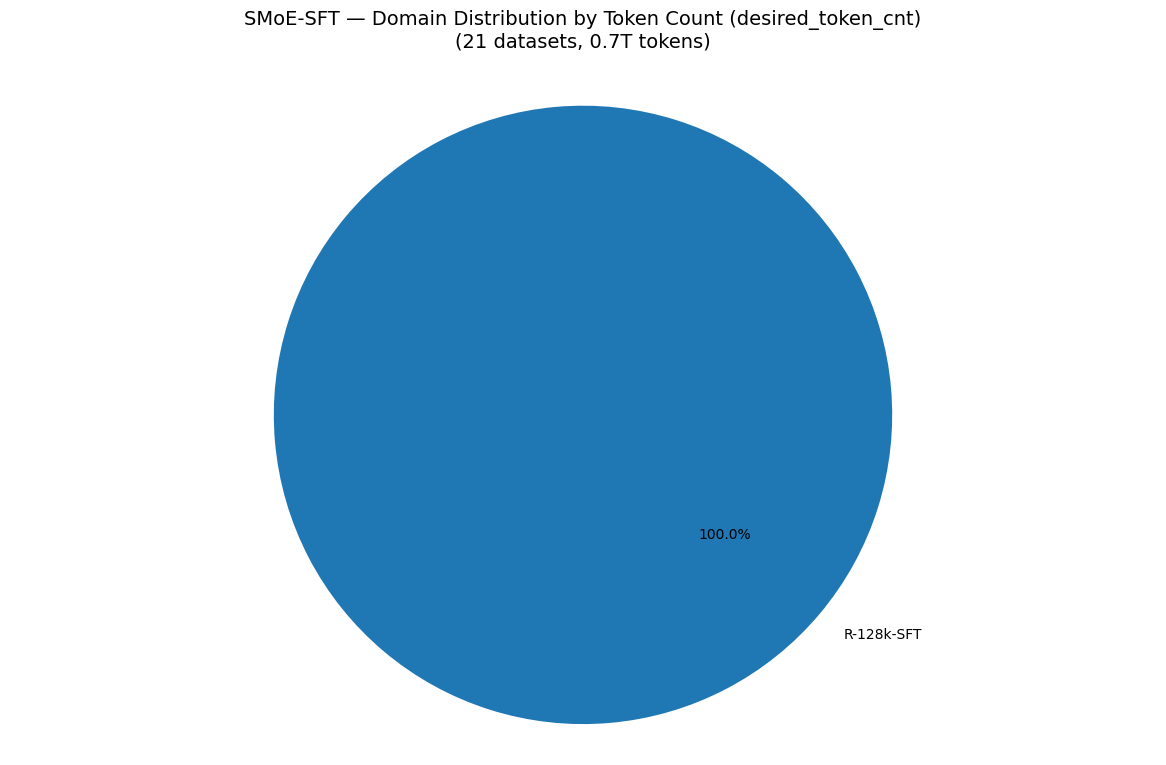

In [9]:
# Pie chart by token count — one plot per phase
phases = df['phase'].unique()
n_phases = len(phases)

for phase in phases:
    phase_df = df_domain[df_domain['phase'] == phase]
    domain_tokens = phase_df.groupby('domain')[TOKEN_COL].sum().sort_values(ascending=False)

    total = domain_tokens.sum()
    pct = (domain_tokens / total) * 100
    large = domain_tokens[pct >= 1.5]
    small = domain_tokens[pct < 1.5]

    if not small.empty:
        plot_data = pd.concat([large, pd.Series({'Other': small.sum()})])
    else:
        plot_data = large

    plt.figure(figsize=(12, 8))
    wedges, texts, autotexts = plt.pie(
        plot_data, labels=plot_data.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 10}
    )

    if not small.empty:
        legend_labels = [f"{d} ({pct[d]:.1f}%)" for d in small.index]
        plt.legend(legend_labels, title=f"'Other' ({len(small)} domains)",
                   loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.title(f'{phase} — Domain Distribution by Token Count ({TOKEN_COL})\n({len(phase_df)} datasets, {total/1e12:.1f}T tokens)', fontsize=14, pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

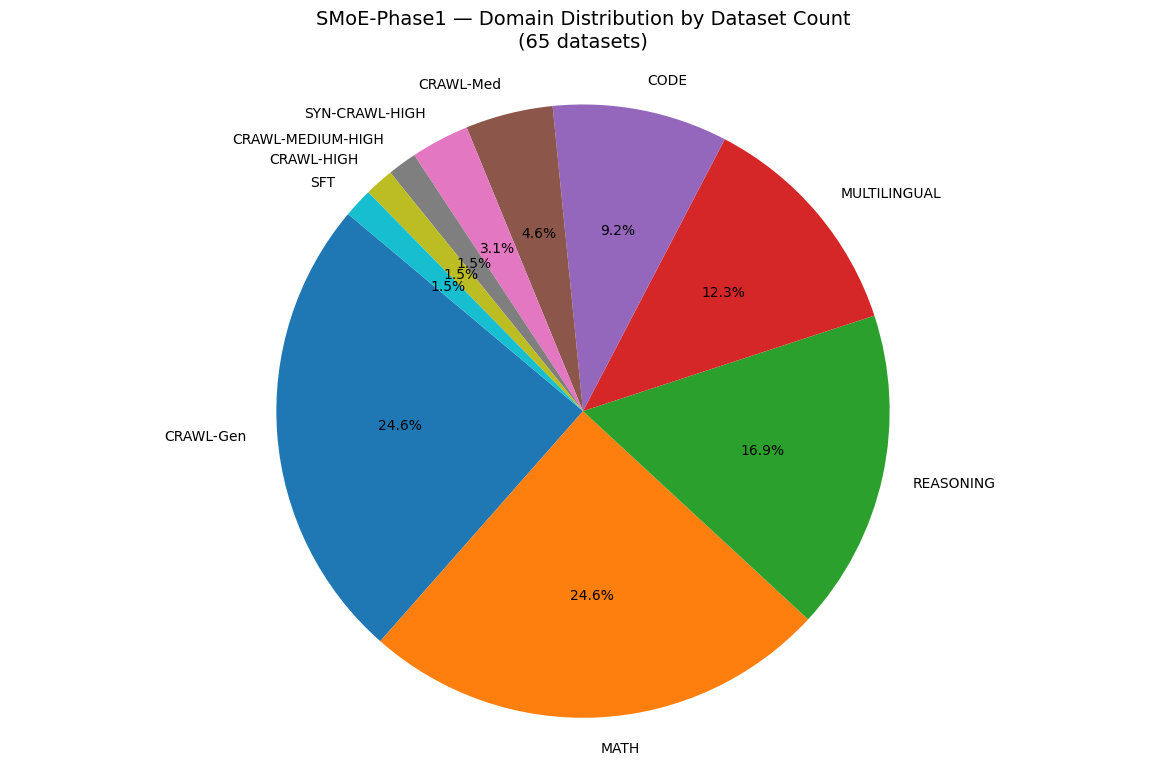

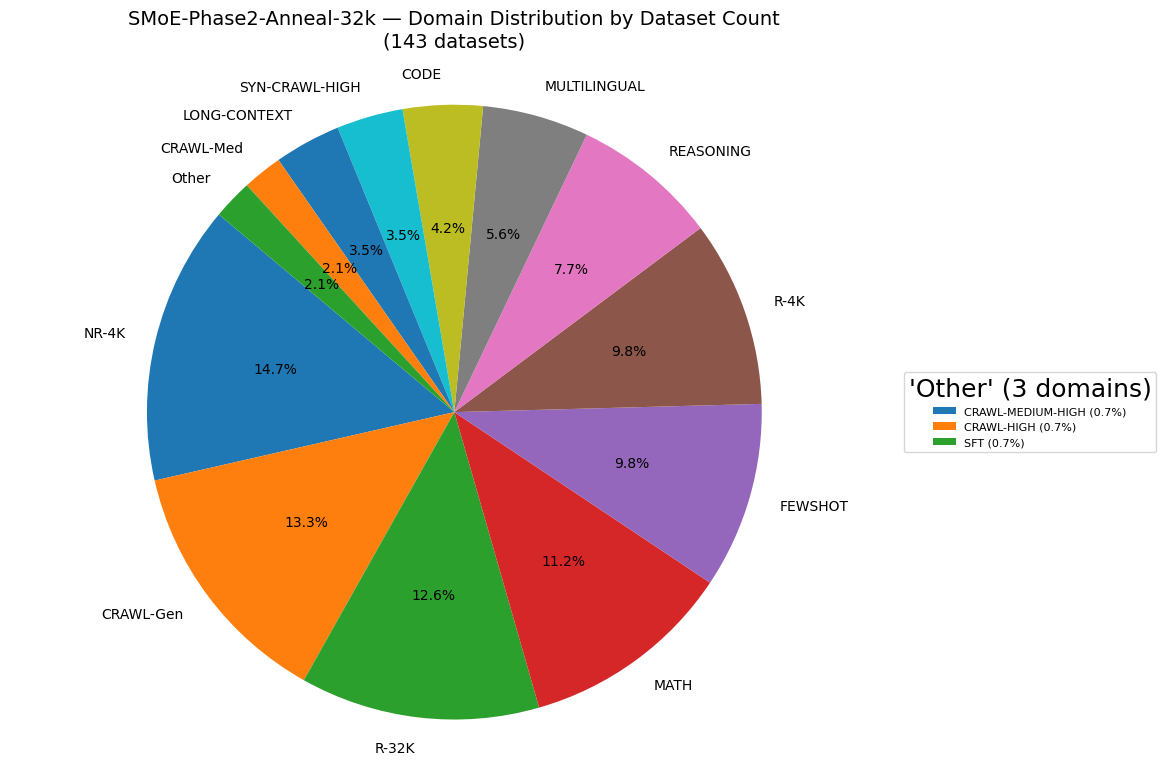

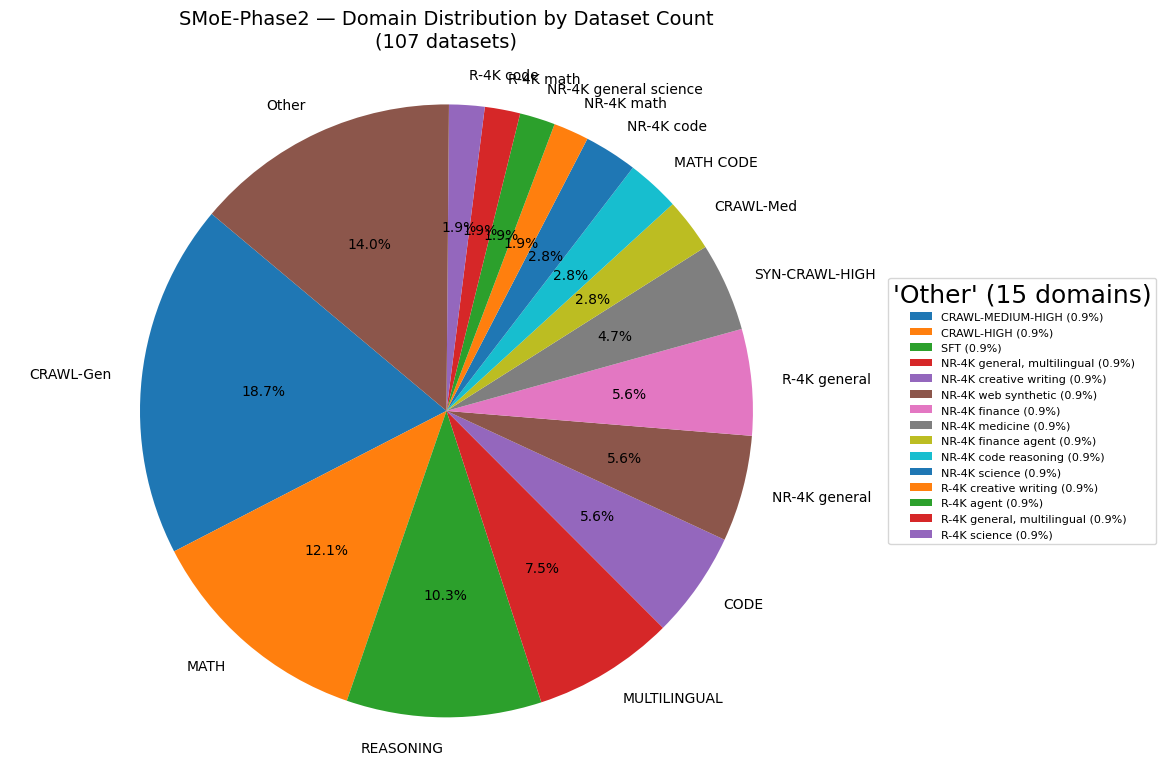

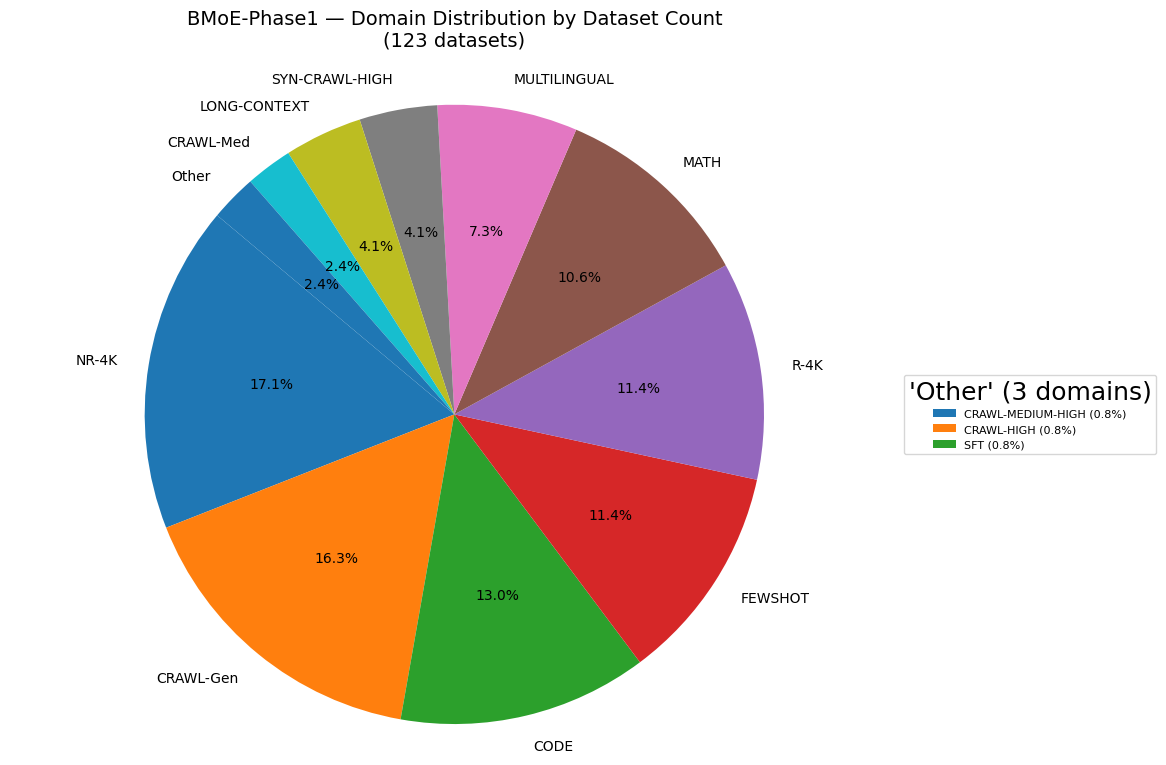

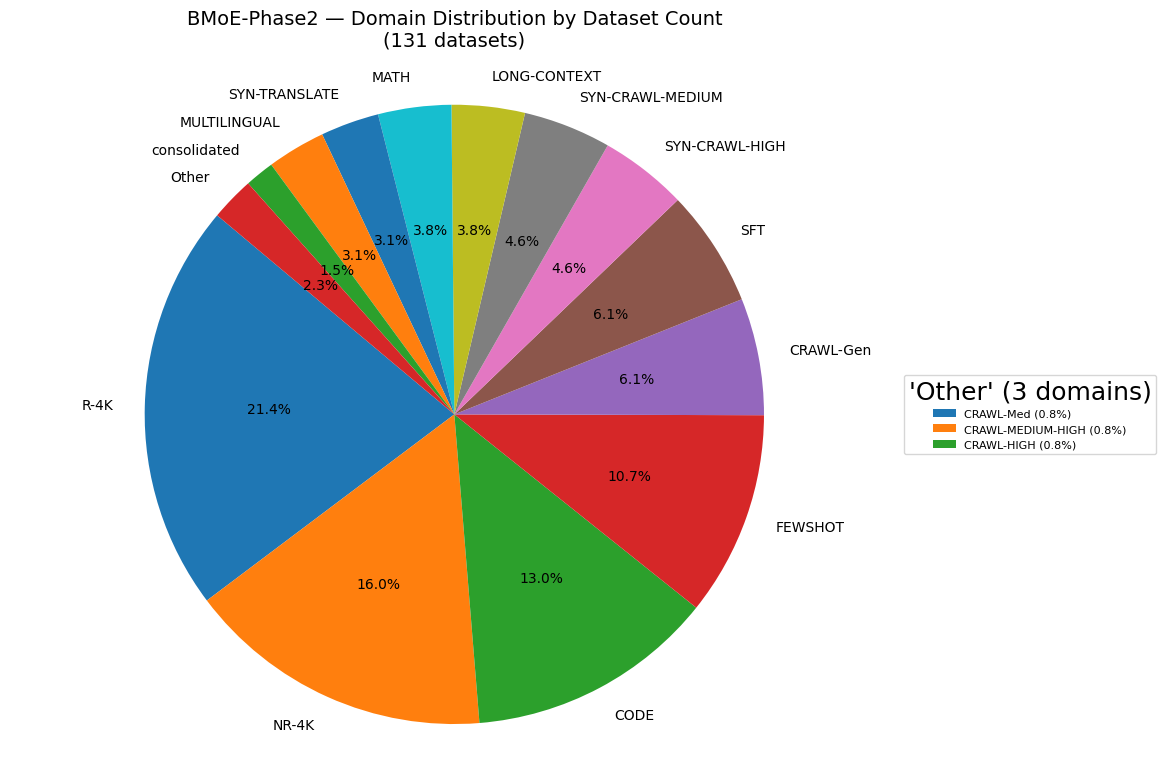

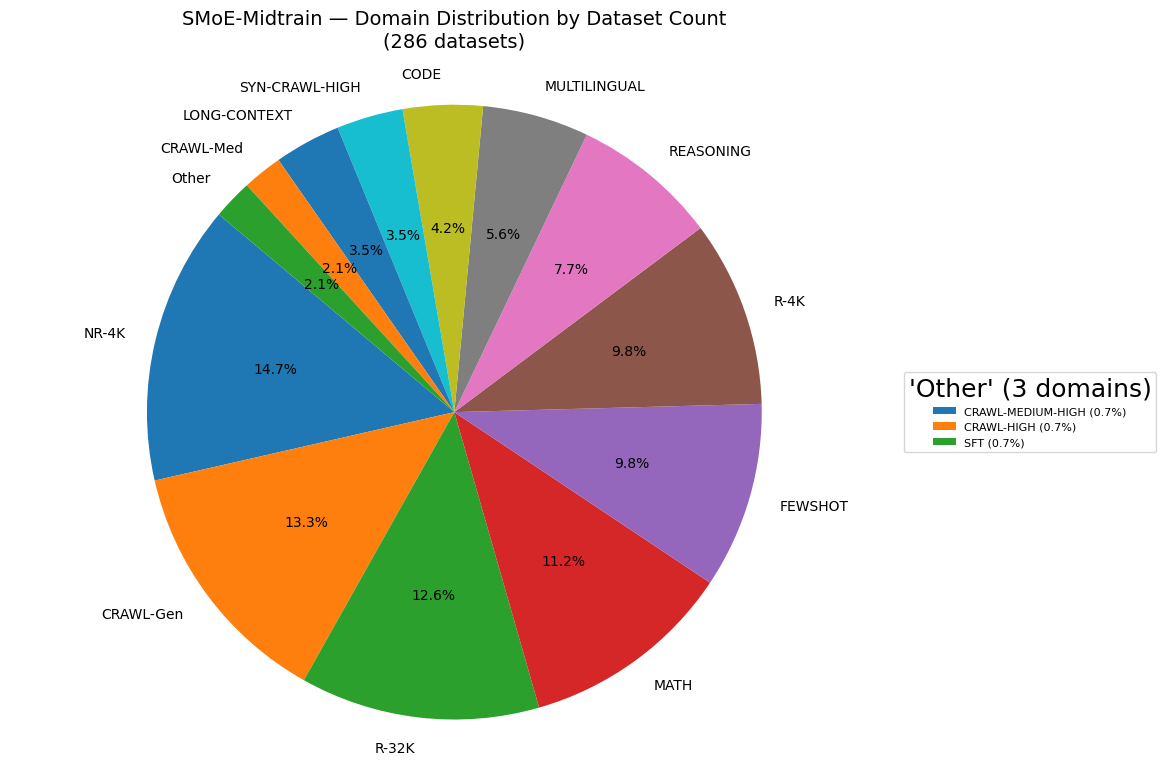

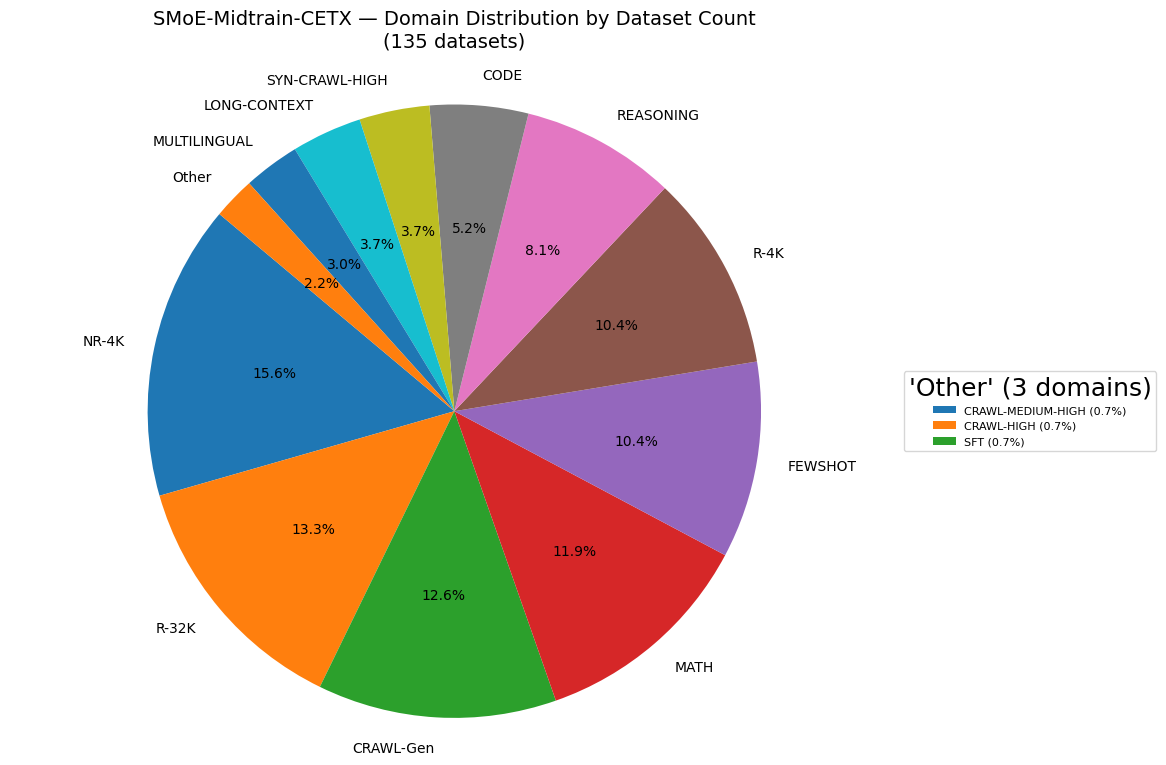

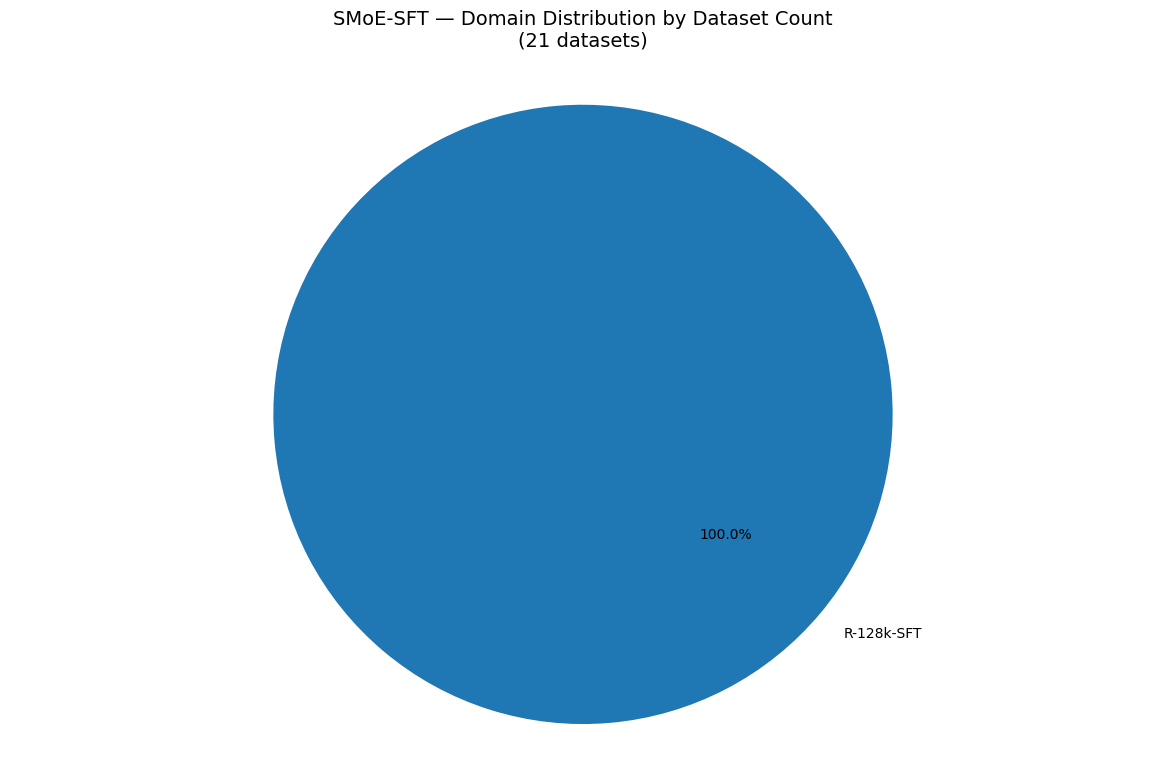

In [10]:
# Pie chart by dataset count — one plot per phase
for phase in phases:
    phase_df = df_domain[df_domain['phase'] == phase]
    domain_counts = phase_df['domain'].value_counts()

    total = domain_counts.sum()
    pct = (domain_counts / total) * 100
    large = domain_counts[pct >= 1.5]
    small = domain_counts[pct < 1.5]

    if not small.empty:
        plot_data = pd.concat([large, pd.Series({'Other': small.sum()})])
    else:
        plot_data = large

    plt.figure(figsize=(12, 8))
    wedges, texts, autotexts = plt.pie(
        plot_data, labels=plot_data.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 10}
    )

    if not small.empty:
        legend_labels = [f"{d} ({pct[d]:.1f}%)" for d in small.index]
        plt.legend(legend_labels, title=f"'Other' ({len(small)} domains)",
                   loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.title(f'{phase} — Domain Distribution by Dataset Count\n({total} datasets)', fontsize=14, pad=20)
    plt.axis('equal')
    plt.tight_layout()
    # plt.savefig(f'{phase}_domain_distribution_count.png', dpi=200, bbox_inches='tight')
    plt.show()

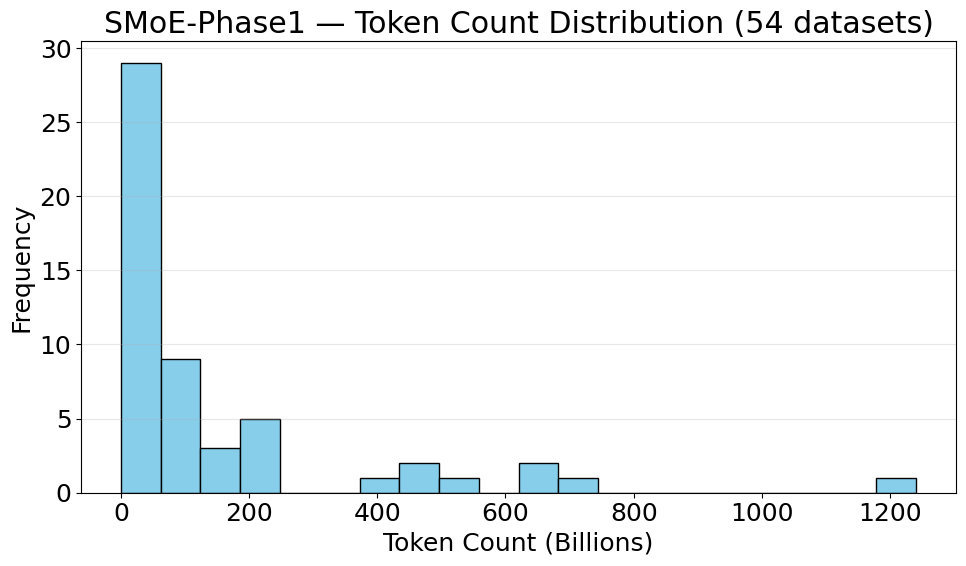

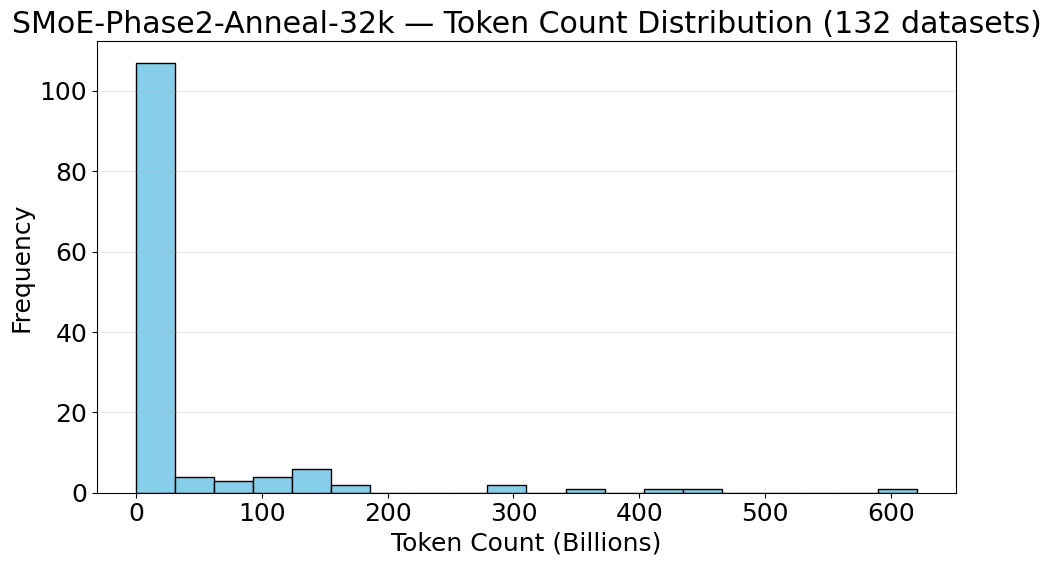

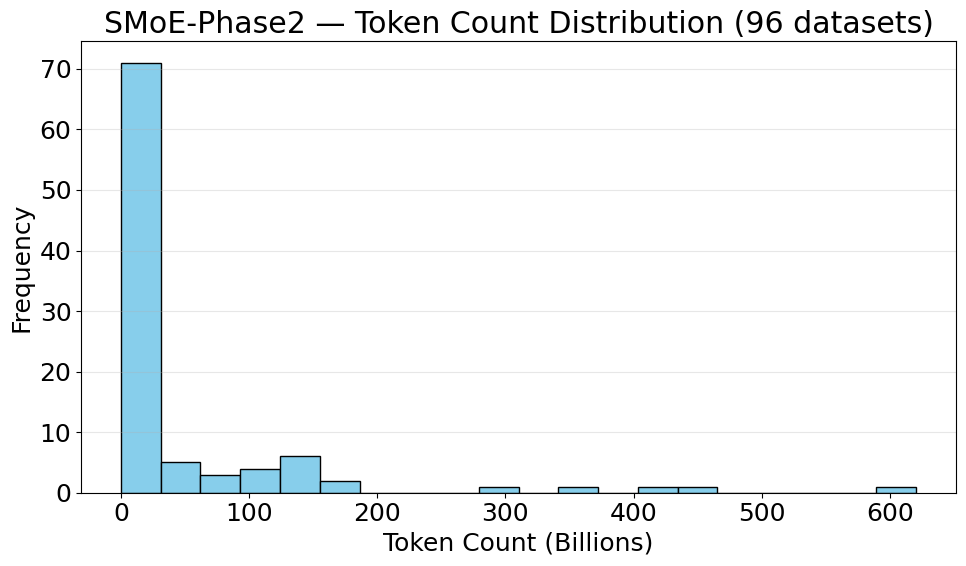

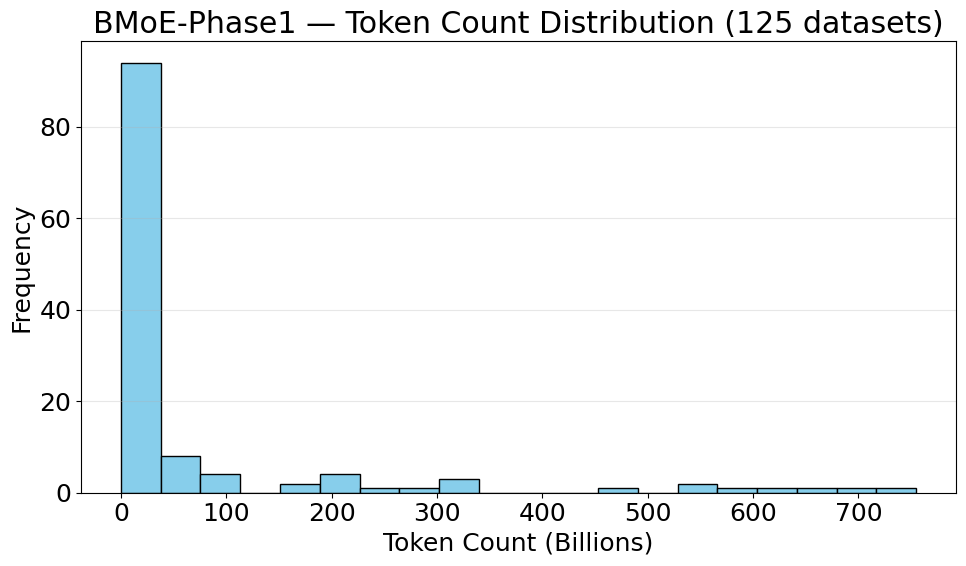

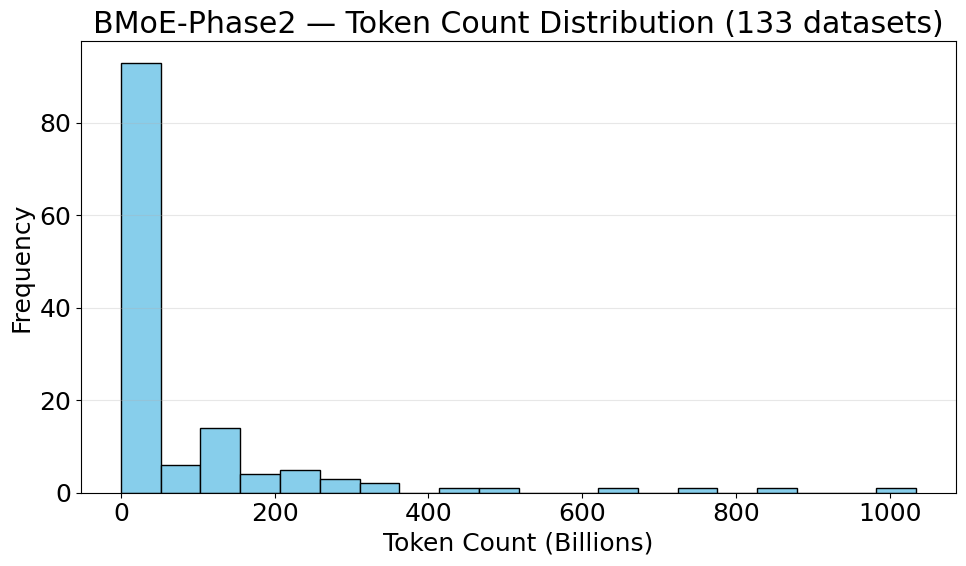

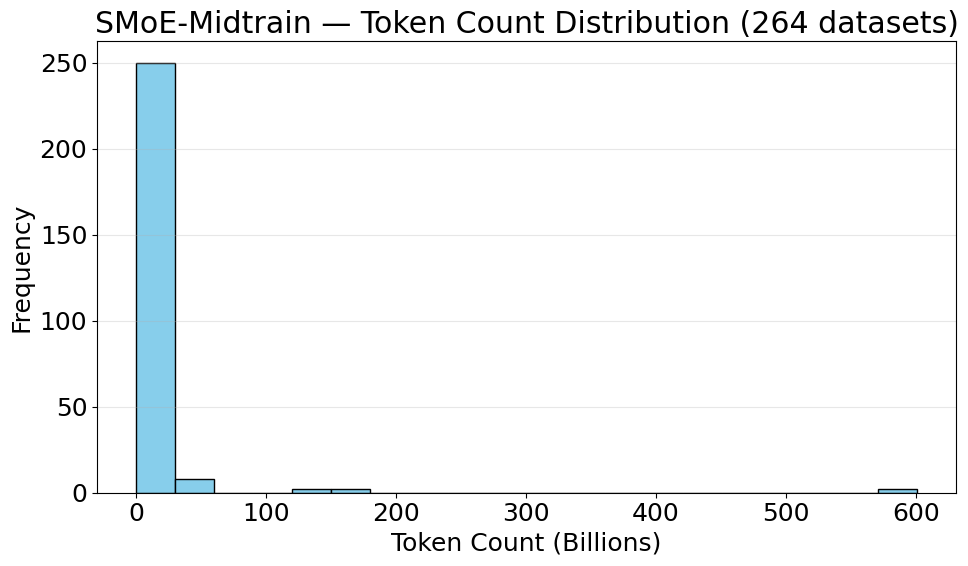

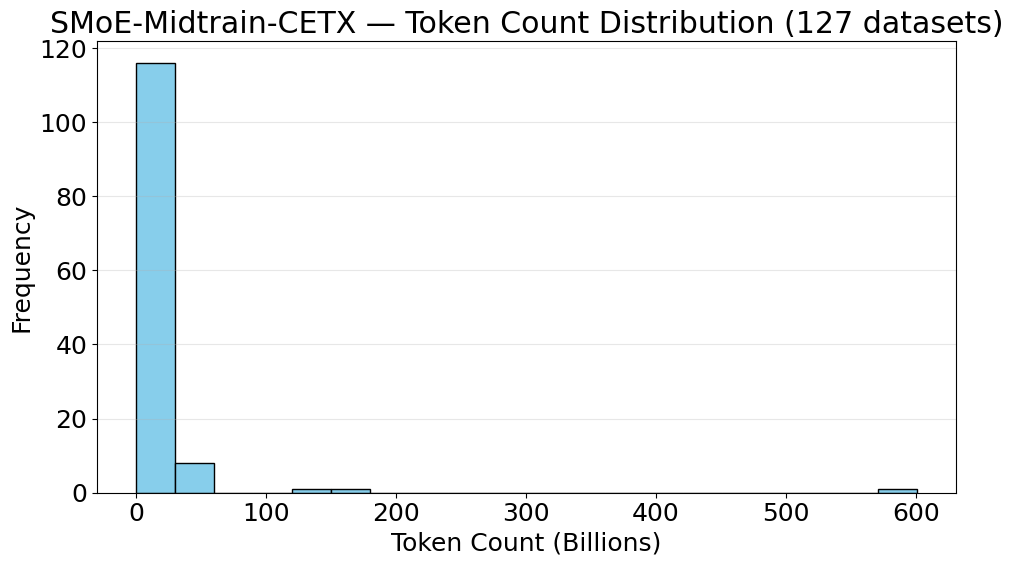

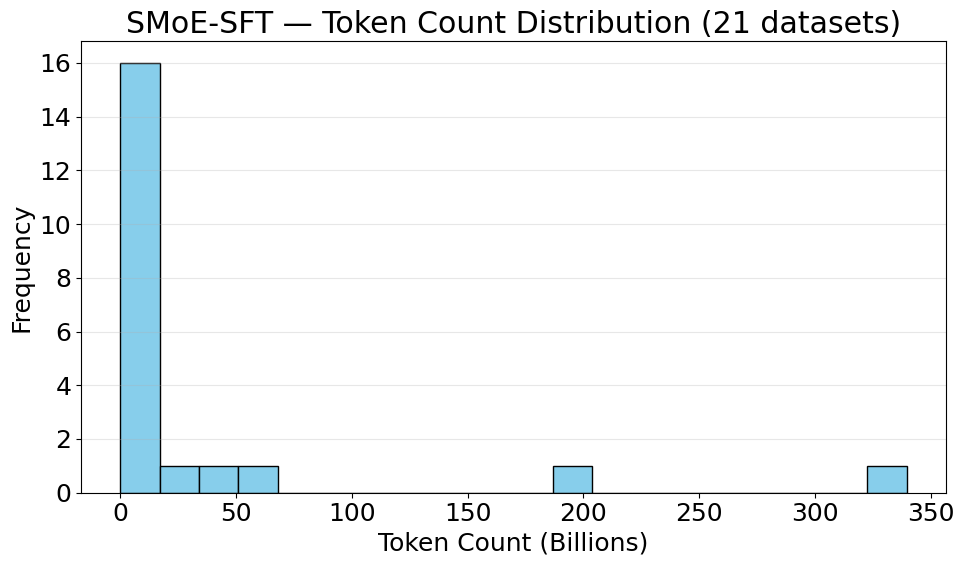

In [11]:
# Overall histogram — one plot per phase
for phase in phases:
    phase_data = df[df['phase'] == phase][TOKEN_COL].dropna()
    if phase_data.empty:
        print(f'{phase}: no valid data')
        continue

    plt.figure(figsize=(10, 6))
    plt.hist(phase_data / 1e9, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Token Count (Billions)')
    plt.ylabel('Frequency')
    plt.title(f'{phase} — Token Count Distribution ({len(phase_data)} datasets)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

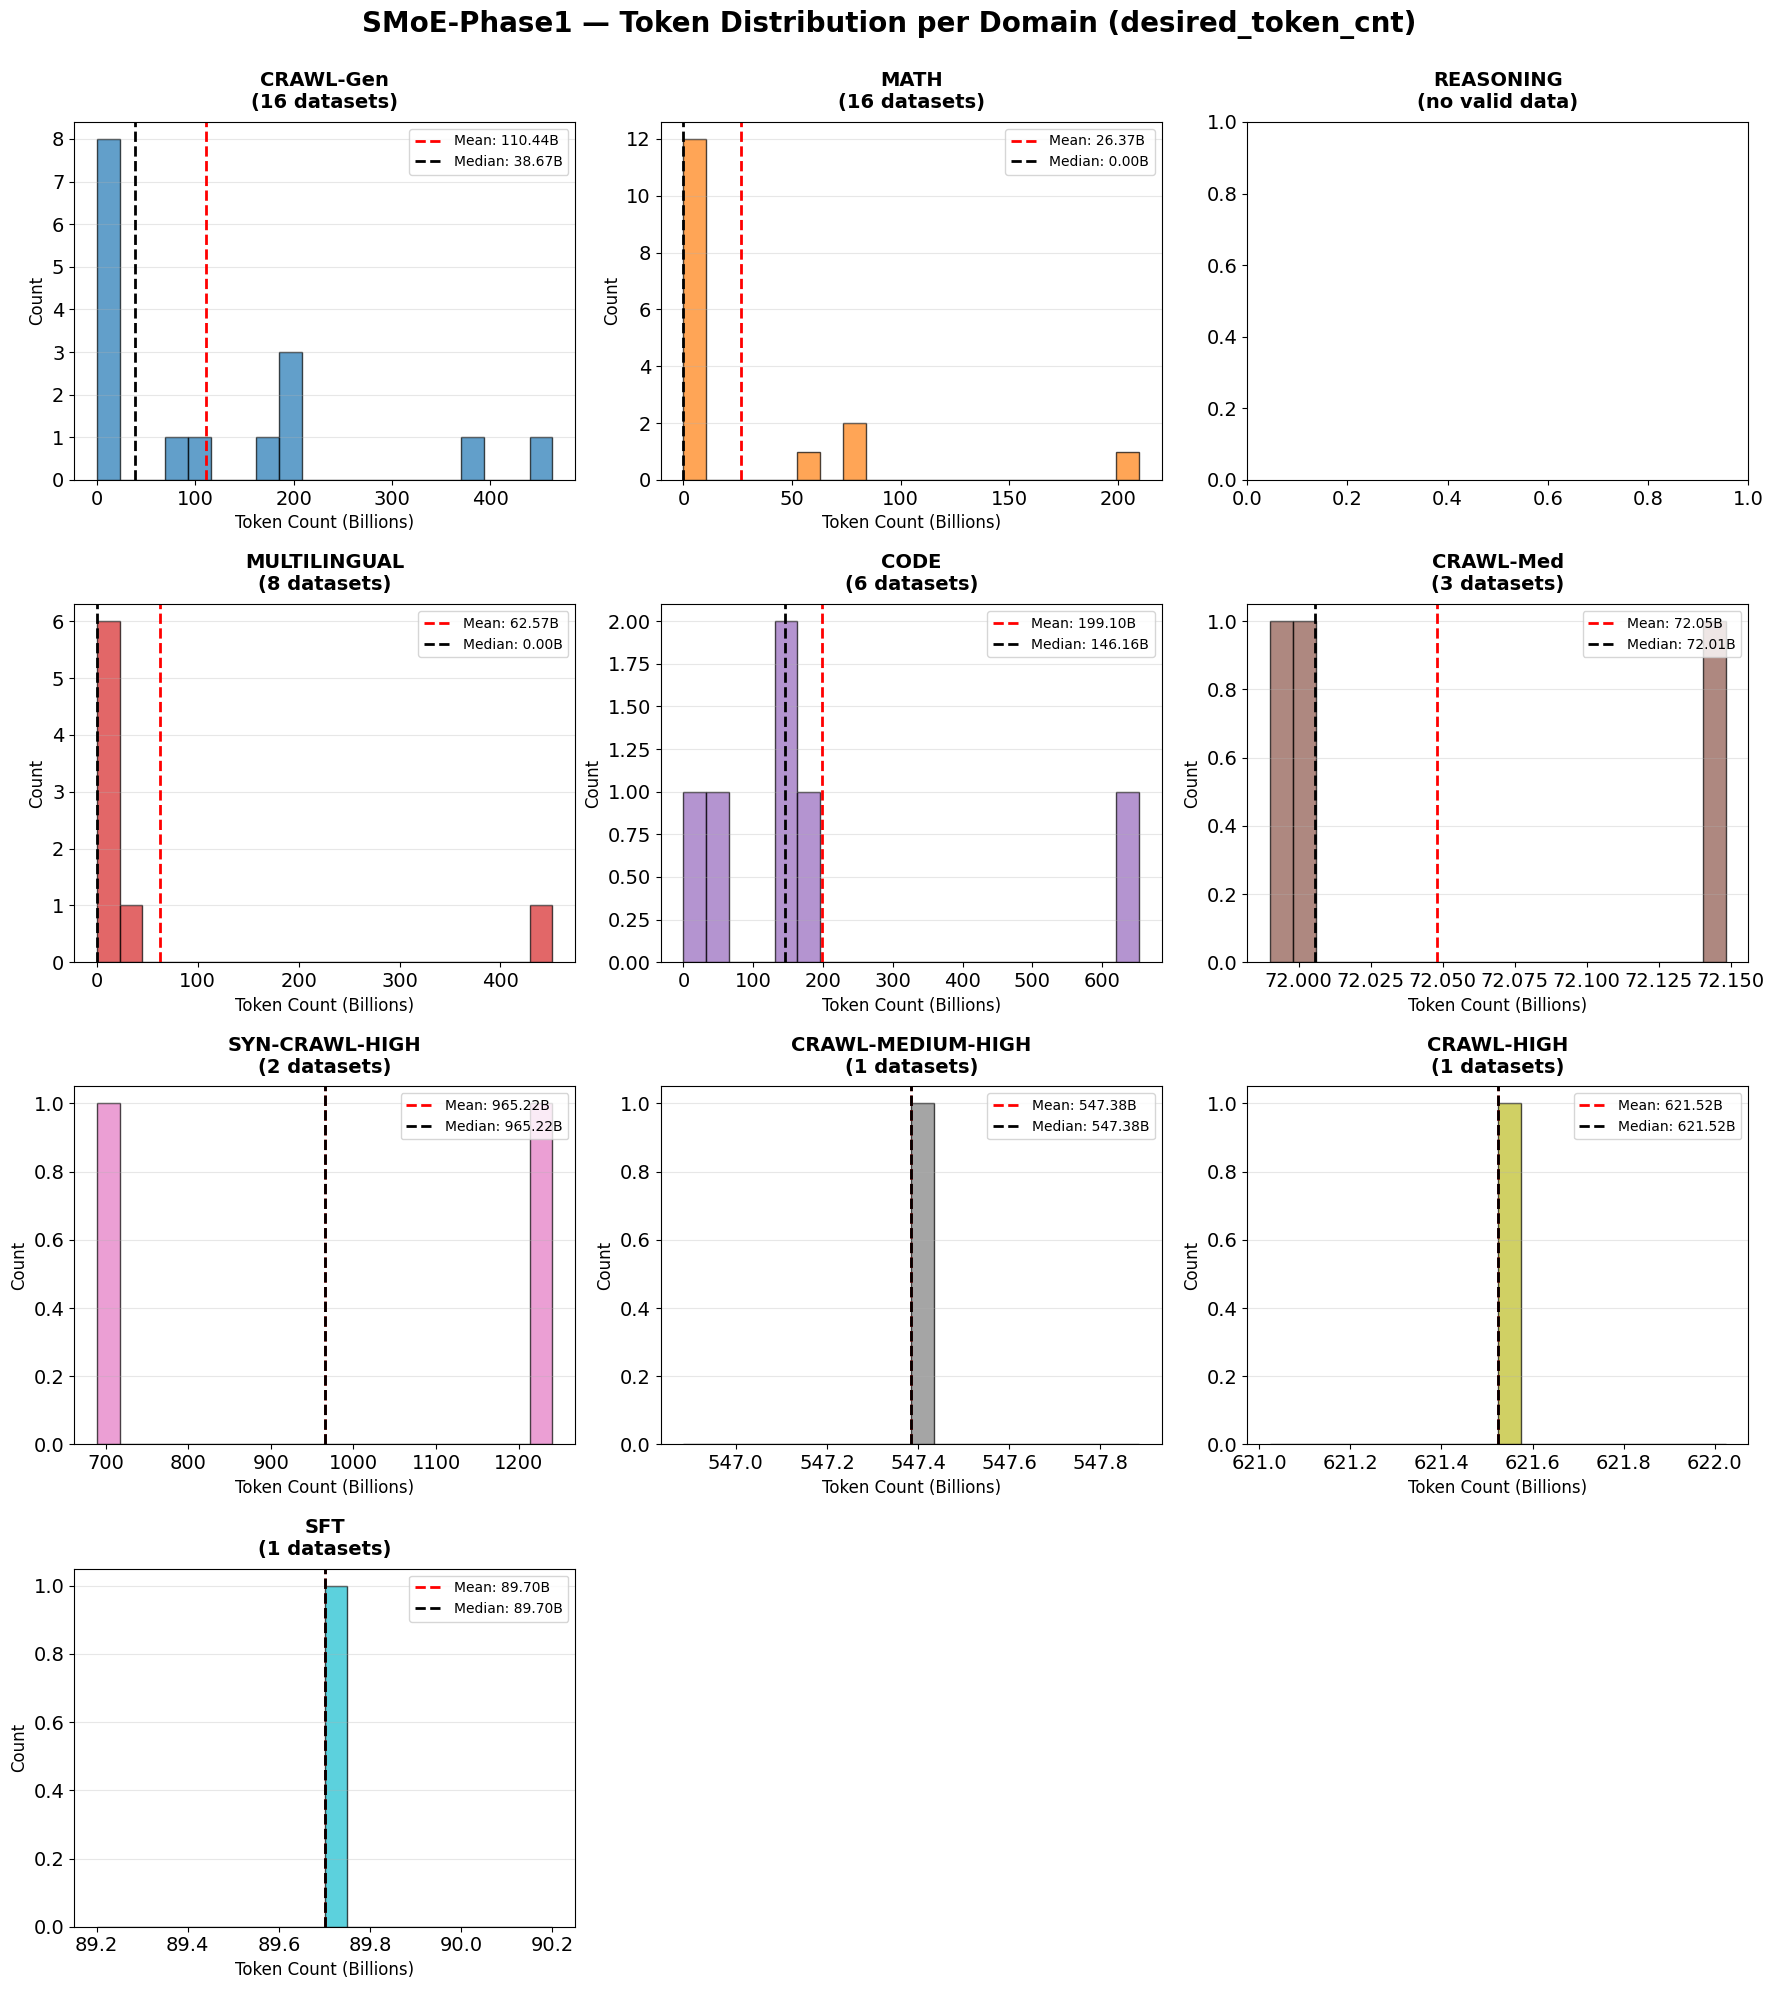

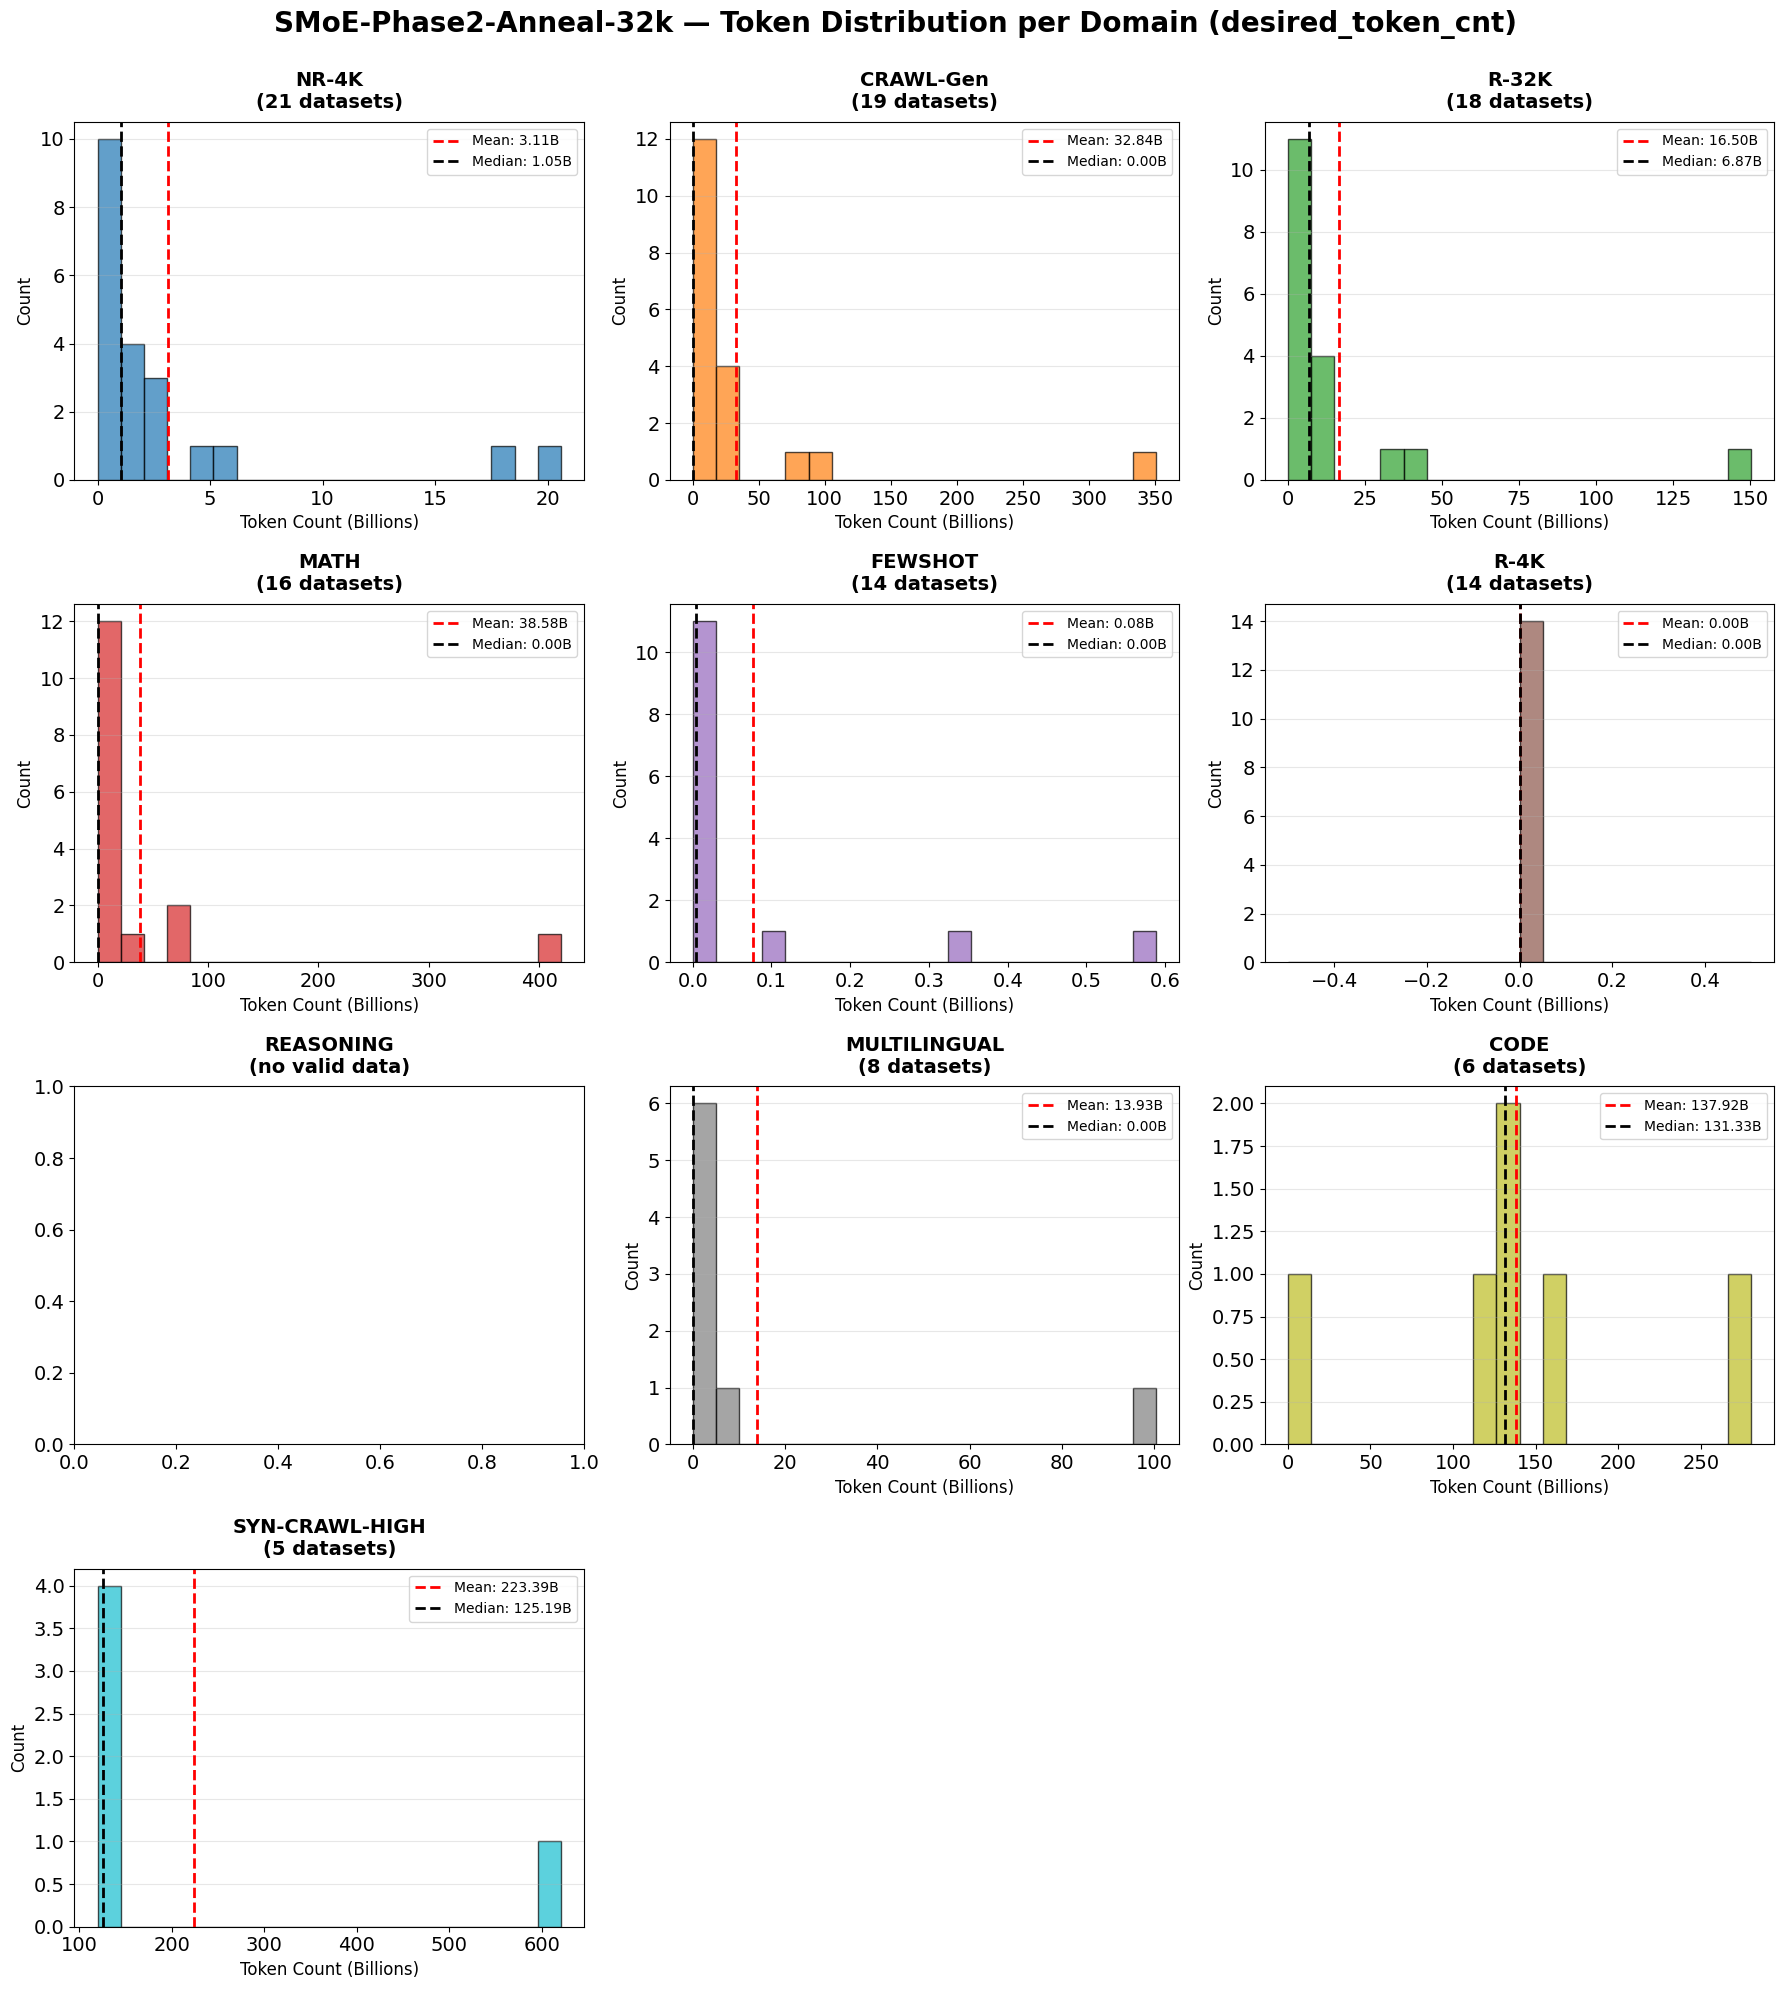

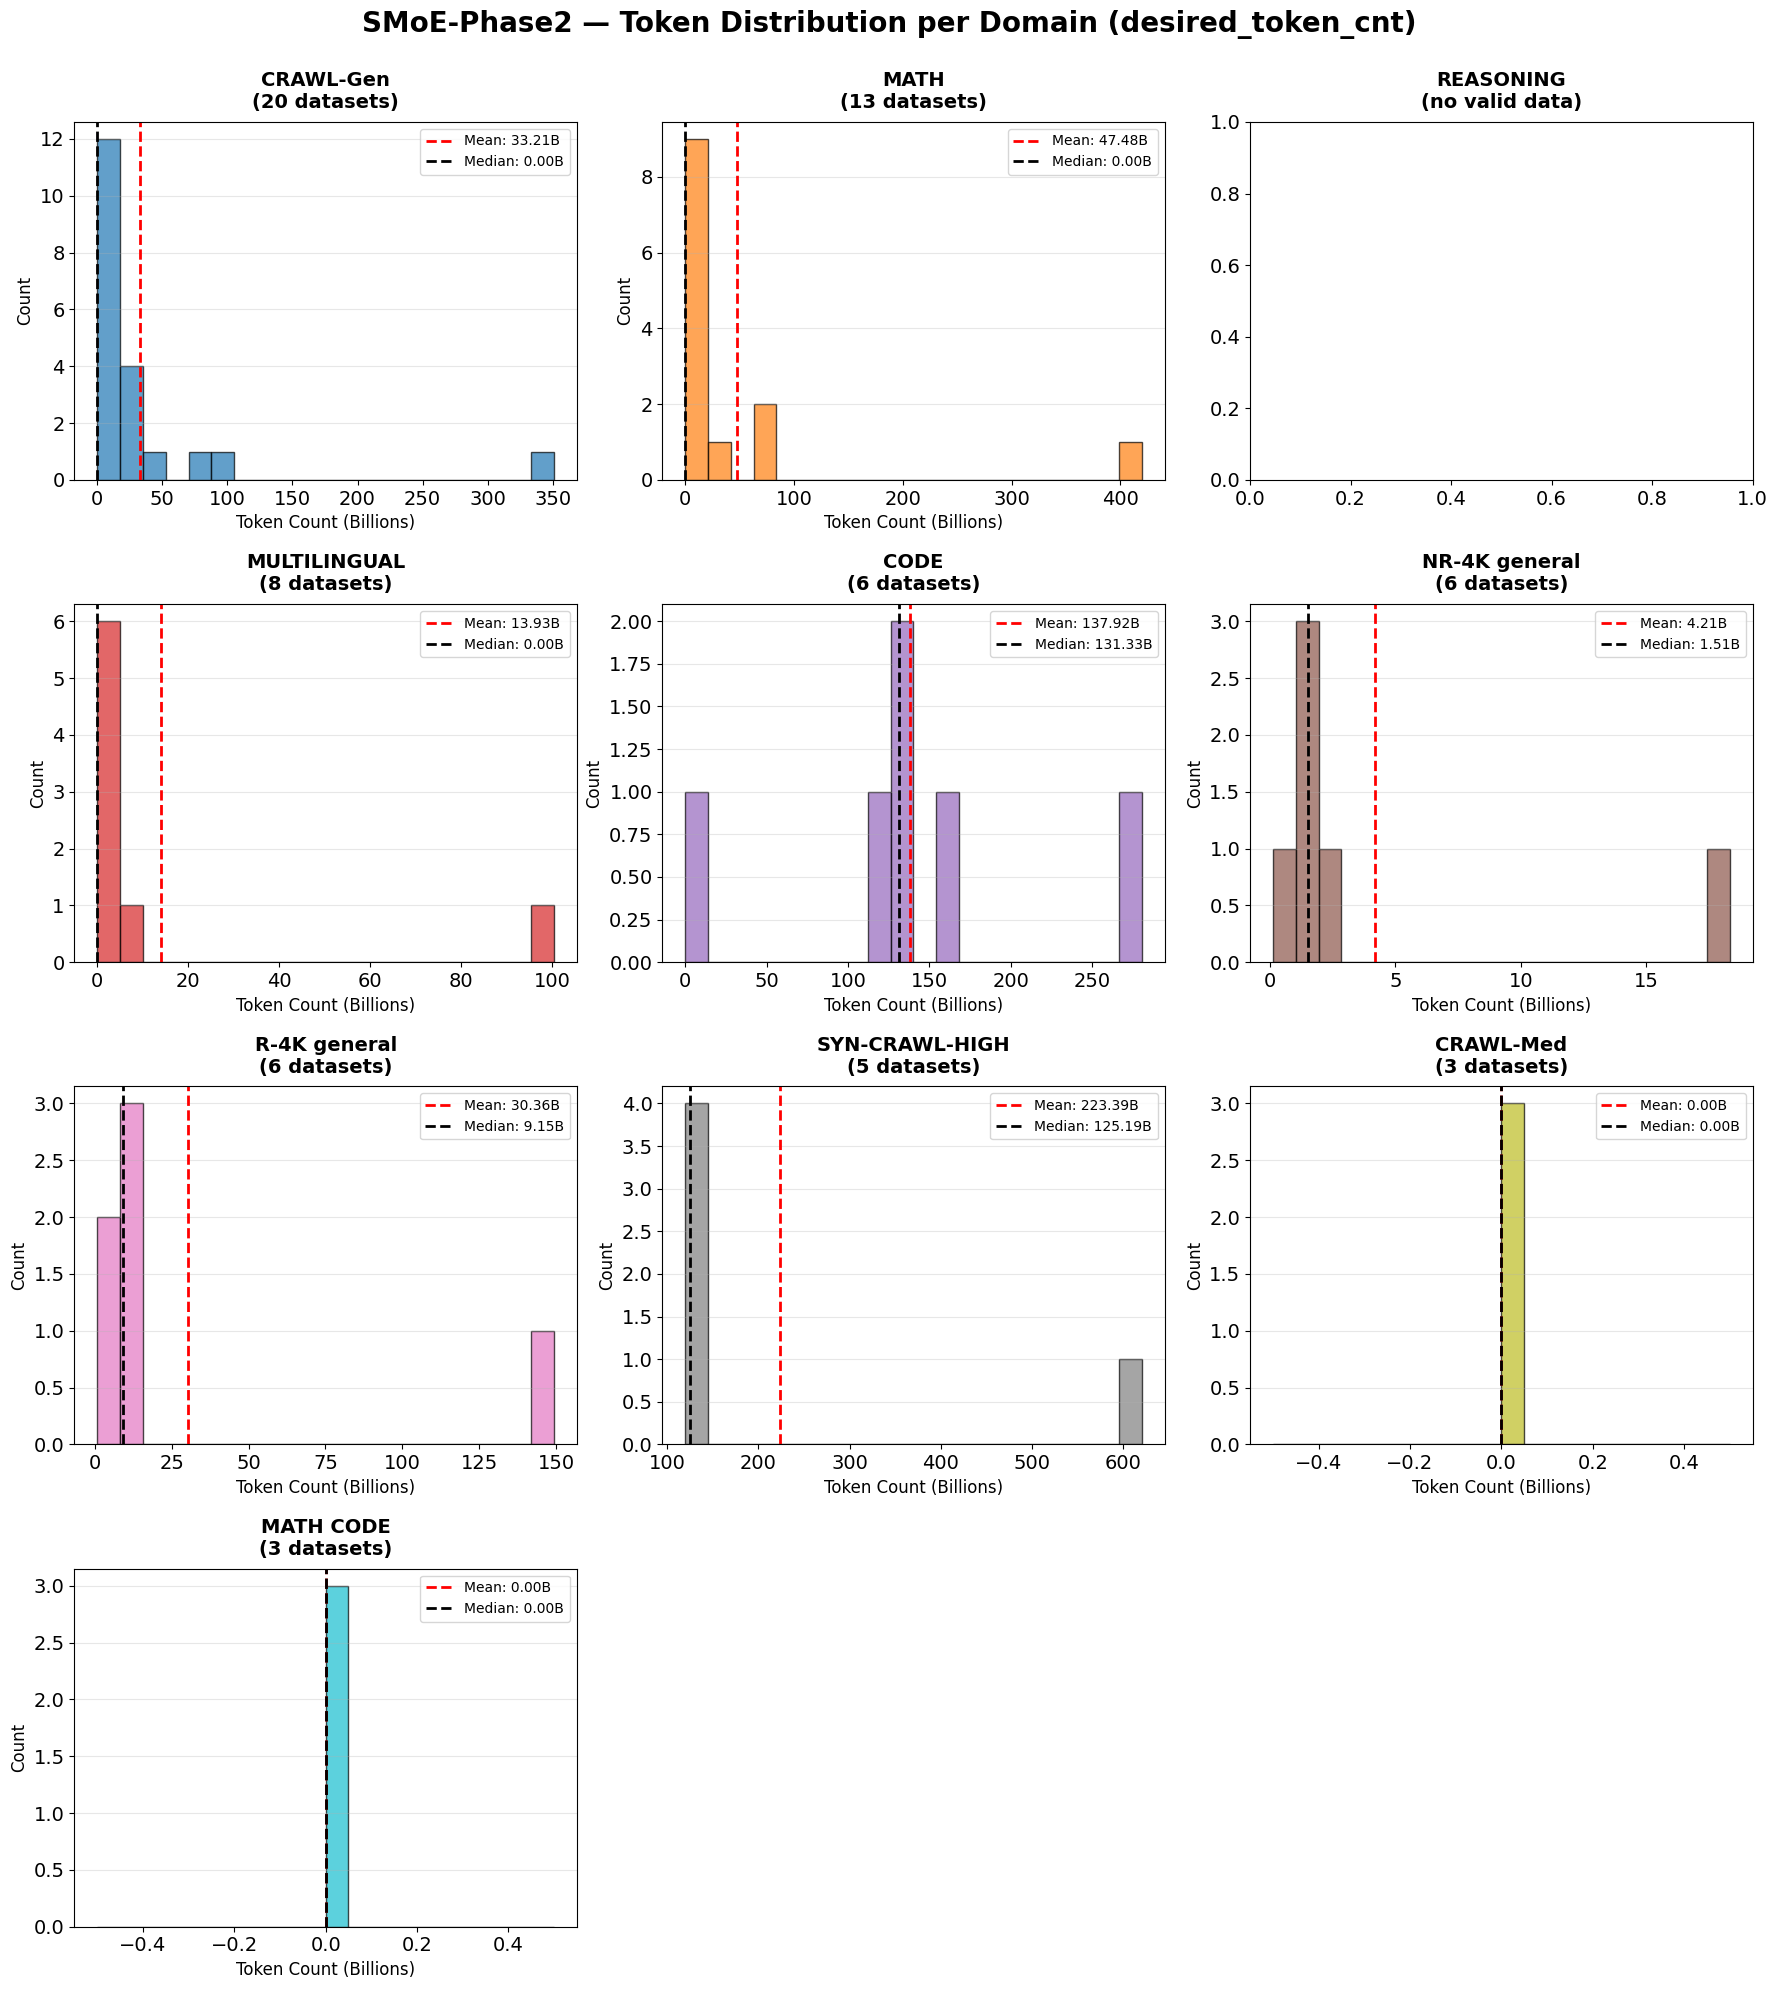

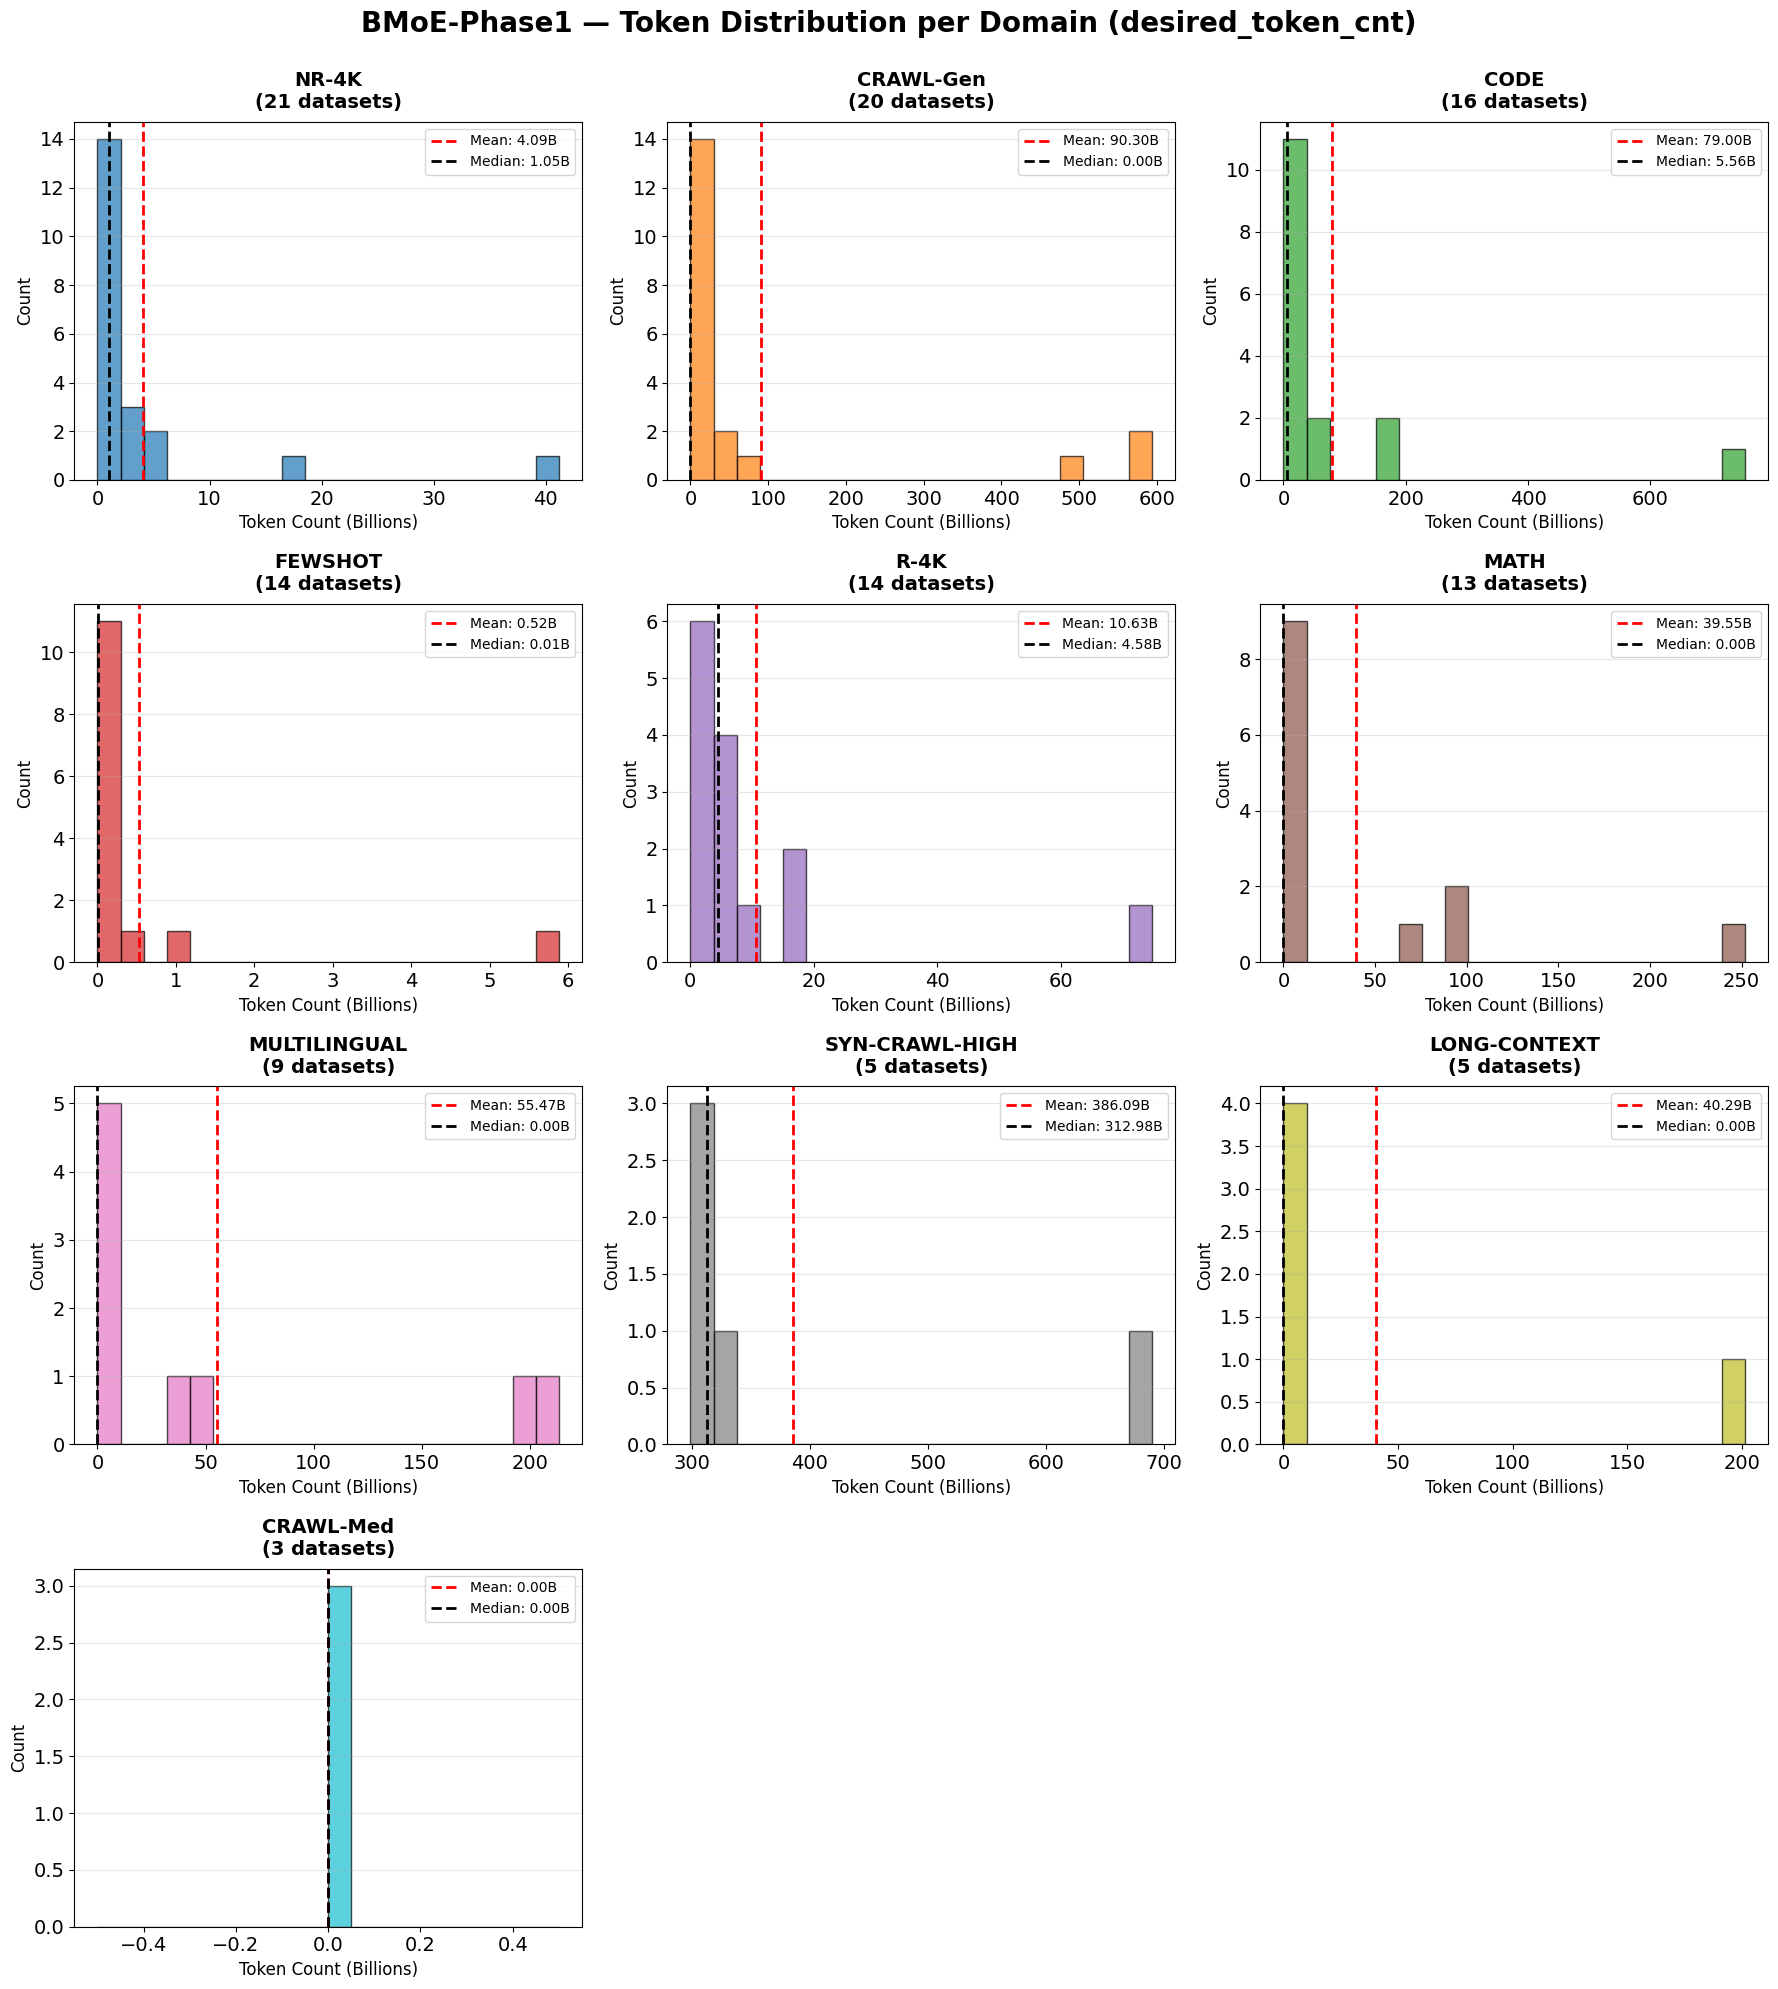

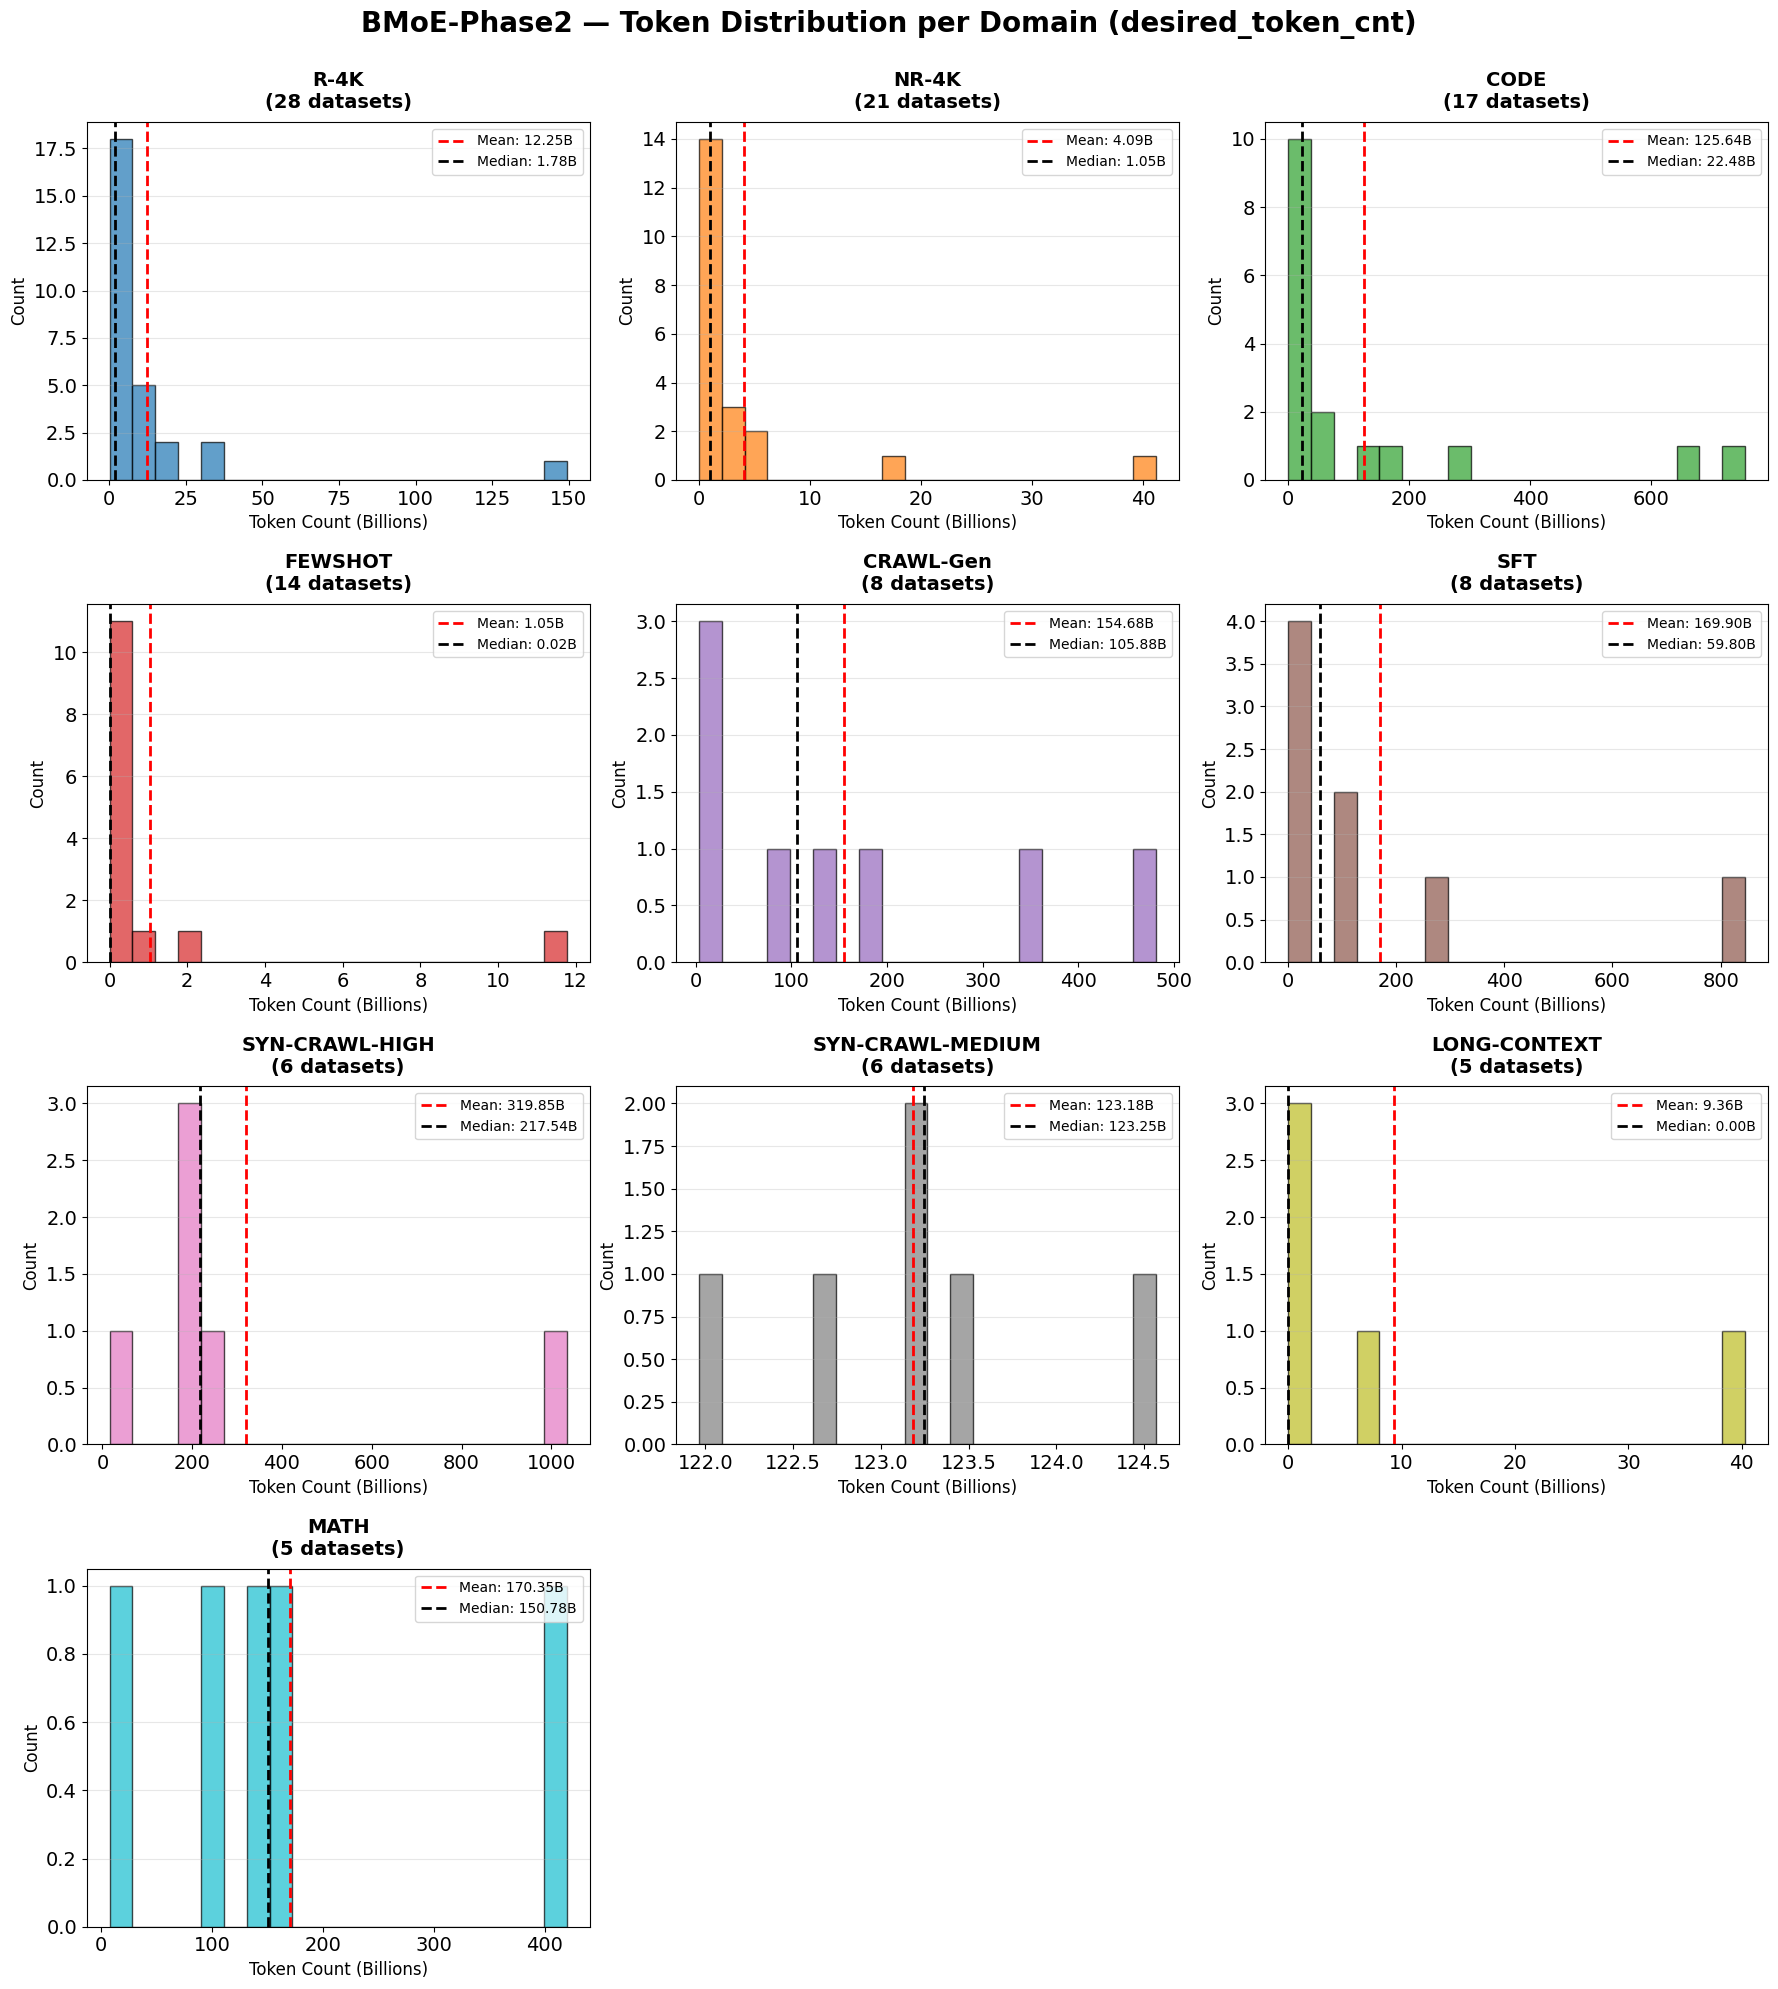

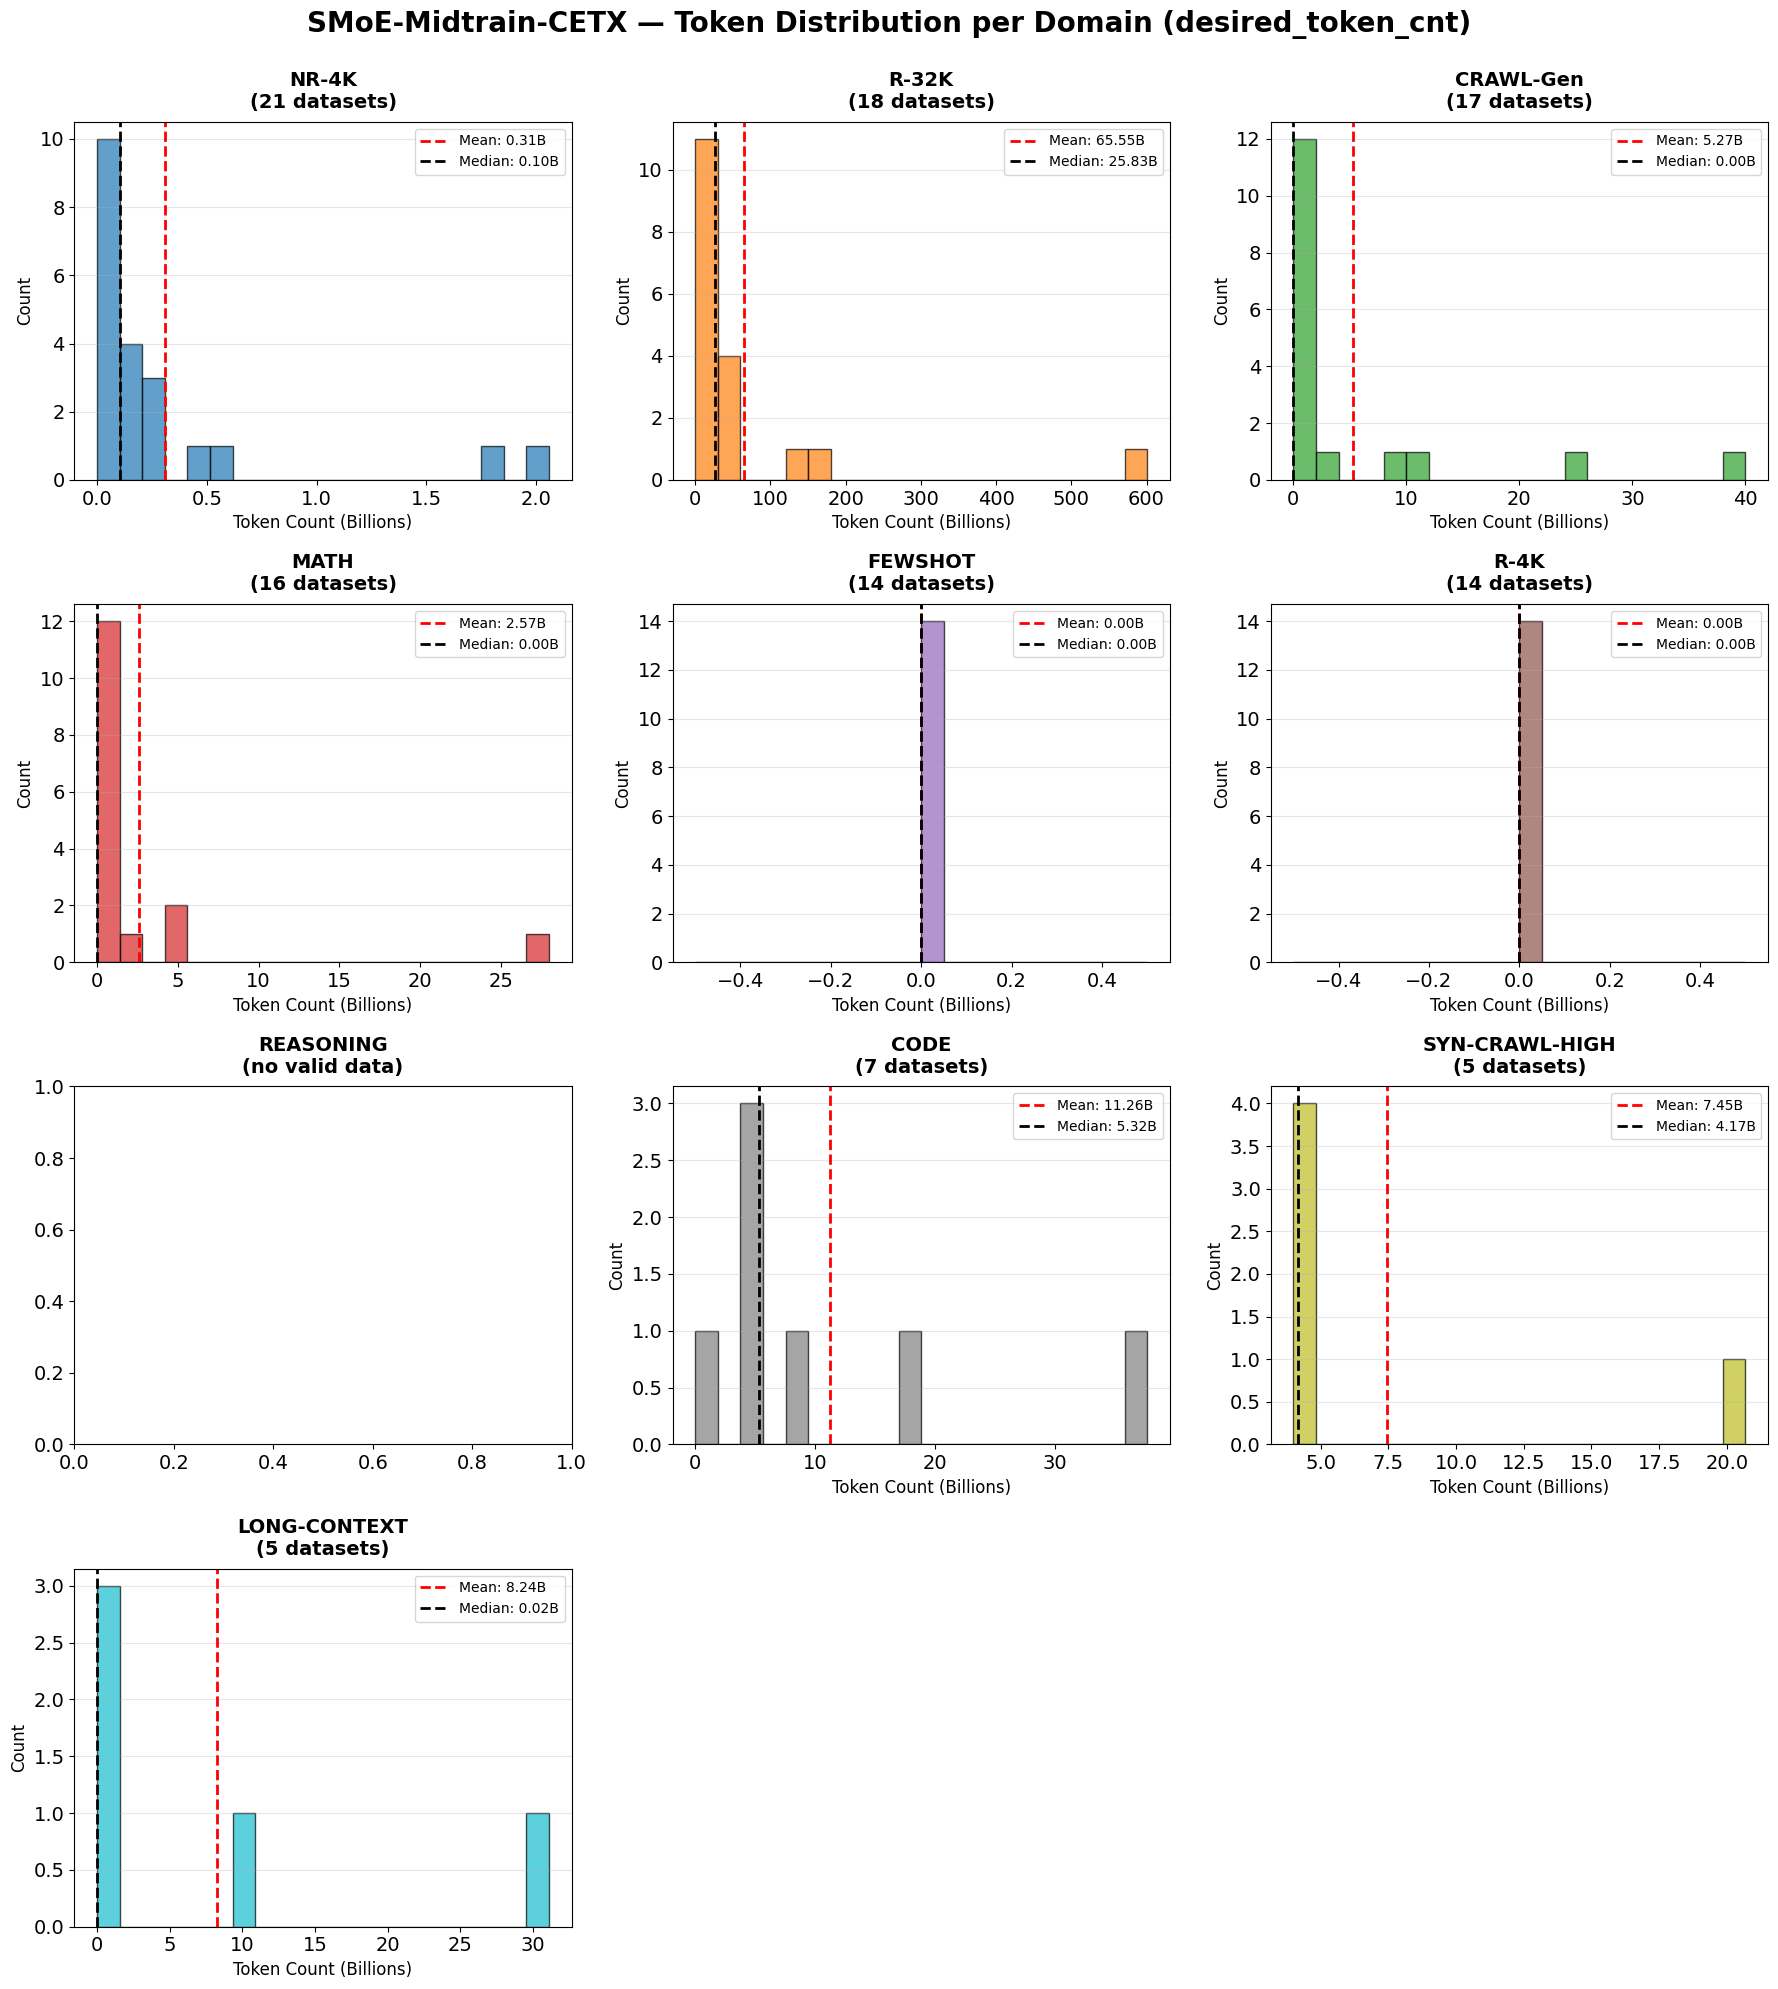

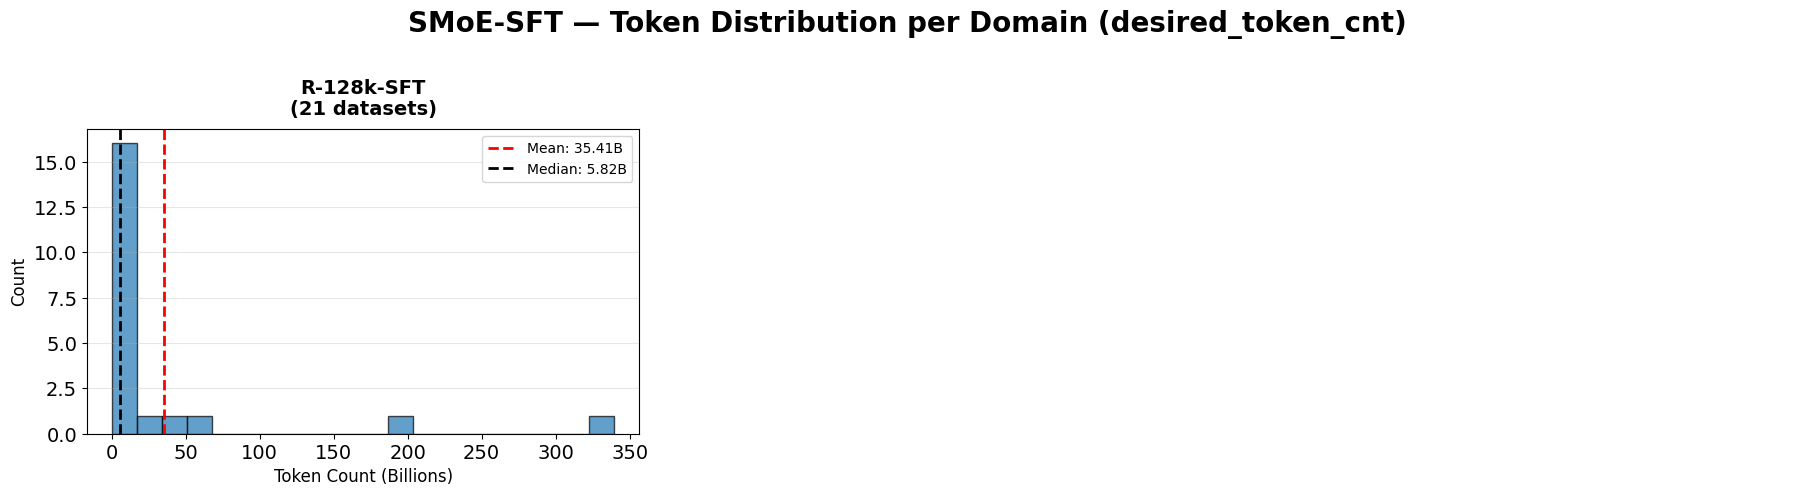

In [12]:
# Per-domain histograms — one grid per phase
plt.rcParams.update({'font.size': 14})

for phase in phases:
    phase_df = df_domain[df_domain['phase'] == phase]
    top_domains = phase_df['domain'].value_counts().head(10).index
    n_domains = len(top_domains)

    if n_domains == 0:
        continue

    n_cols = 3
    n_rows = int(np.ceil(n_domains / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    if n_domains == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    colors = plt.cm.tab10(np.linspace(0, 1, max(n_domains, 2)))

    for idx, domain in enumerate(top_domains):
        data = phase_df[phase_df['domain'] == domain][TOKEN_COL].dropna()
        ax = axes[idx]
        if data.empty:
            ax.set_title(f'{domain}\n(no valid data)', fontsize=14, fontweight='bold', pad=10)
            continue
        ax.hist(data / 1e9, bins=20, edgecolor='black', alpha=0.7, color=colors[idx])
        ax.set_title(f'{domain}\n({len(data)} datasets)', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Token Count (Billions)', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.grid(axis='y', alpha=0.3)

        mean_val = data.mean() / 1e9
        median_val = data.median() / 1e9
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}B')
        ax.axvline(median_val, color='k', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}B')
        ax.legend(fontsize=10, loc='upper right')

    for idx in range(n_domains, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'{phase} — Token Distribution per Domain ({TOKEN_COL})', fontsize=20, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

## Upload to Database

Create a new `datasets` table with the simplified schema and insert all rows.

In [13]:
cols_upload = ['dataset_id', 'data_name_split', 'domain', 'gemma3_token_cnt', 'epochs', 
               'desired_token_cnt', 'training_stage', 'link', 'ibm_datapath']

In [14]:
# Generate dataset_id in the format DS-000001, DS-000002, etc.
df['dataset_id'] = [f'DS-{str(i).zfill(6)}' for i in range(1, len(df) + 1)]

In [15]:
df.columns

Index(['data_name_split', 'domain', 'weblink', 'Size \n(processed_gemma3)',
       'Documents', 'gemma3_token_cnt', 'Epochs', 'Desired Tokens (for 10T)',
       'Megatron Weights', 'ibm_datapath', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'VP local location of gemma3 tokenized (as of 8/5/25)',
       'Megatron prefix', 'Comments', 'desired_token_cnt', 'phase', 'Link',
       'Desired Tokens (for 8T)', 'Weights', 'Phase2 Epochs', 'Desired Tokens',
       'Unnamed: 15', 'Unnamed: 9', 'dataset_id'],
      dtype='str')

In [16]:
df['training_stage'] = df['phase']
df['epochs'] = df['Epochs'] 
df['link'] = df['Link'] 


In [17]:
df_upload = df[cols_upload]

In [18]:
# The upload function now handles its own imports

In [19]:
def upload_dataframe_to_db(df, dbname='dataset_tracking', user='antoniorodriguez', host='localhost', port=5432):
    """
    Upload a pandas DataFrame to the PostgreSQL database.
    
    DataFrame should have columns:
    - dataset_id (formatted as DS-000001, DS-000002, etc.)
    - data_name_split
    - domain
    - gemma3_token_cnt
    - epochs (or Epochs)
    - desired_token_cnt
    - training_stage (or phase)
    - link (or Link)
    - ibm_datapath
    """
    import psycopg2
    from psycopg2.extras import execute_values
    
    # Rename columns to match database
    df = df.copy()
    if 'Epochs' in df.columns:
        df = df.rename(columns={'Epochs': 'epochs'})
    if 'phase' in df.columns:
        df = df.rename(columns={'phase': 'training_stage'})
    
    conn = None
    cur = None
    
    try:
        # Connect to database
        conn = psycopg2.connect(
            host=host,
            port=port,
            dbname=dbname,
            user=user,
            password=''
        )
        cur = conn.cursor()
        
        # Prepare data for insertion
        columns = ['dataset_id', 'data_name_split', 'domain', 'gemma3_token_cnt', 'epochs', 
                   'desired_token_cnt', 'training_stage', 'link', 'ibm_datapath']
        
        # Convert DataFrame to list of tuples
        data = []
        for _, row in df.iterrows():
            values = []
            for col in columns:
                val = row.get(col)
                # Handle NaN values
                if pd.isna(val):
                    # training_stage cannot be null, provide default
                    if col == 'training_stage':
                        values.append('Unknown')
                    else:
                        values.append(None)
                else:
                    values.append(val)
            data.append(tuple(values))
        
        # Clear existing data (optional)
        clear_existing = input("Clear existing data? (yes/no): ").lower() == 'yes'
        if clear_existing:
            cur.execute("TRUNCATE TABLE datasets RESTART IDENTITY CASCADE;")
            conn.commit()
            print("✓ Cleared existing data")
        
        # Insert new data
        insert_query = """
            INSERT INTO datasets (dataset_id, data_name_split, domain, gemma3_token_cnt, epochs, 
                                  desired_token_cnt, training_stage, link, ibm_datapath)
            VALUES %s
        """
        
        execute_values(cur, insert_query, data)
        conn.commit()
        
        print(f"✓ Inserted {len(data)} rows")
        
        # Verify
        cur.execute("SELECT COUNT(*) FROM datasets;")
        count = cur.fetchone()[0]
        print(f"✓ Total rows in database: {count}")
        
    except Exception as e:
        if conn:
            conn.rollback()
        print(f"✗ Error: {e}")
        raise
    finally:
        # Always close cursor and connection
        if cur:
            cur.close()
        if conn:
            conn.close()
        print("✓ Database connection closed")

In [20]:

upload_dataframe_to_db(df_upload)

✓ Cleared existing data
✓ Inserted 1018 rows
✓ Total rows in database: 1018
✓ Database connection closed


## Simple Test for uploading CSV

In [21]:
import pandas as pd

In [22]:


# Create sample data matching your schema
data = { 'dataset_id': [
        'DS-100001',
        'DS-100002',
        'DS-100003',
        'DS-100004',
        'DS-100005'],
    'data_name_split': [
        'experiment_1',
        'experiment_2',
        'experiment_3',
        'experiment_4',
        'experiment_5'
    ],
    'domain': [
        'CRAWL-Gen',
        'SFT',
        'CRAWL-Gen',
        'SFT',
        'CRAWL-Gen'
    ],
    'gemma3_token_cnt': [
        1.5e12,  # 1.5 trillion
        5.0e11,  # 500 billion
        2.3e12,  # 2.3 trillion
        1.0e11,  # 100 billion
        8.5e11   # 850 billion
    ],
    'epochs': [
        0.5,
        1.0,
        0.25,
        2.0,
        0.75
    ],
    'desired_token_cnt': [
        3.0e12,
        1.0e12,
        5.0e12,
        2.0e11,
        1.2e12
    ],
    'training_stage': [
        'SMoE-Phase1',
        'BMoE-Phase2',
        'SMoE-Phase1',
        'BMoE-Phase2',
        'SMoE-Phase1'
    ],
    'link': [
        'https://huggingface.co/datasets/experiment-1',
        'https://huggingface.co/datasets/experiment-2',
        '',  # Empty link is OK
        'https://huggingface.co/datasets/experiment-4',
        'https://github.com/experiment-5'
    ]
}

# Create DataFrame
df_exp = pd.DataFrame(data)

# Display it
print(df_exp)

# Export to CSV
df_exp.to_csv('/Users/antoniorodriguez/Desktop/experiment_data.csv', index=False)

  dataset_id data_name_split     domain  gemma3_token_cnt  epochs  \
0  DS-100001    experiment_1  CRAWL-Gen      1.500000e+12    0.50   
1  DS-100002    experiment_2        SFT      5.000000e+11    1.00   
2  DS-100003    experiment_3  CRAWL-Gen      2.300000e+12    0.25   
3  DS-100004    experiment_4        SFT      1.000000e+11    2.00   
4  DS-100005    experiment_5  CRAWL-Gen      8.500000e+11    0.75   

   desired_token_cnt training_stage  \
0       3.000000e+12    SMoE-Phase1   
1       1.000000e+12    BMoE-Phase2   
2       5.000000e+12    SMoE-Phase1   
3       2.000000e+11    BMoE-Phase2   
4       1.200000e+12    SMoE-Phase1   

                                           link  
0  https://huggingface.co/datasets/experiment-1  
1  https://huggingface.co/datasets/experiment-2  
2                                                
3  https://huggingface.co/datasets/experiment-4  
4               https://github.com/experiment-5  
